<a href="https://colab.research.google.com/github/samuel0922/AA-Team_SSAMJI/blob/main/CropDiseaseDetection_FasterRCNN_0926PP_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Title : Crop Disease Detection using Faster R-CNN with Python (v.0926PP-B)
* 제출용 기본 코드 : 파일명 변경, 파일 내용 정리
* 기본코드F + Bbox augmentation : F R-CNN모델 기반의 병해검출 기본코드에 바운딩박스 Augmentation 적용
* Epoch : 1 적용

* 업데이트 부분 : list는 .to(cpu) 안된다는 오류는 해소됨
* 새로운 오류 : transforms의 bbox aug 후에.. x_max값이 1보다 큰 것에 대한 오류는 해소
* 9/25 멘토링 내용 반영해서 코드 수정해서 완성
* transforms 적용을 위해 albumentaiton 작업 착수
---

### [ 개요 ]

* 플젝 목  적 : 이미지에서 농작물 병해를 진단하는 Object Detection 모델 구현
* 플젝 내  용 : 
    * 최소 두 개의 Object Detection 모델을 활용해 
    * 이미지에서 농작물을 구분하고 병해의 종류와 병해의 진행상태를 진단하는 코드를 구현하고,
    * 두 모델 간의 성능을 비교하며, 
    * 다양한 전처리 기법들을 교차적용해 보면서 해당 Task에 가장 좋은 성능을 발휘하는 전처리 방법셋을 찾아내고
    * 이를 적용해 최종 모델을 구현함

* 사용 모  델 : 
    * Faster R-CNN with pretrained FasterRcnn_Resent50_FPN,
    * RetinaNet

* 사용 데이터 : 데이콘 AI-Cahallege-for-Plant-Classification Dataset

<br>

### [ 목차 ]

* STEP 0. 환경설정
* STEP 1. 데이터 준비
* STEP 2. 데이터 전처리
* STEP 3. 주요 함수 정의
* STEP 4. 커스텀 데이터셋 클래스 및 데이터로더 클래스 정의
* STEP 5. 모델 정의
* STEP 6. 모델 학습
* STEP 7. Inference
* STEP 8. 평가

* 회고

## STEP 0. 환경설정

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# GPU 확인. 코랩에서는 랜덤 GPU할당되므로 메모리 부족현상 발생 가능 -> GPU확인 후 메모리 충분할 경우 진행 권장

import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [3]:
# 라이브러리 임포트

import os
import glob
import json
import shutil as sh

# 바운딩박스 도식화 위한 패키지 임포트
import glob  # 파일, 디렉토리 처리
import matplotlib.pyplot as plt  
import matplotlib.image as mpimg  # matplotlib 시각화
import matplotlib.patches as patches
from bs4 import BeautifulSoup  # HTML, XML 파일 파싱, 웹스크래핑 

from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision  # 이미지 처리를 위해 사용되며 데이터셋에 관한 패키지와 모델에 관한 패키지 내장
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations
import albumentations.pytorch
from matplotlib import pyplot as plt

import random

from tqdm import tqdm
import pandas as pd
from collections import Counter

from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

## STEP 1. 데이터 준비

* 플젝(농작물 병해진단) 데이터셋은 마스크데이터 데이터셋과 다섯 가지 측면에서 차이가 있음
    * 데이터셋 폴더 구조가 다름
    * annotation 파일이 xlm파일이 아니고 json파일인 점
    * bbox 좌표 형식이 다름xml(x1,y1,x2,y2)->json(x,y,h,w)
    * label로 쓸 수 있는 직접적인 항목이 없음
    * 마스크검출에서 바운딩 박스, 레이블은 검출된 객체인 N개의 마스크에 대해서만 annotation에 있는 반면에, 플젝데이터셋의 annotation에는 이미지당 1개씩의 객체와 레이블(로 조합해 활용할 수 있는 항목들)이 있고, 병징을 나타내는 N개의 part에 대한 바운딩박스가 있다는 점에서 차이가 있음.

=> 각각에 대한 처리 방법은
1. 플젝의 데이터 구조를 그냥 두고 필요한 파일을 불러와서 처리하는 방식도 가능하겠지만, 혼란을 줄이고 처리를 용이하게 하기 위해서 디렉토리 구조를 마스크데이터셋처럼 맞춰줌
2. xml파일 대신 json파일에서 필요 정보 파싱해서 사용하면 됨
3. 상이한 좌표형식을 환산식을 사용해 처리
4. label로 쓸 수 있는 항목을 추출해 label로 쓸 수 있는 코드를 생성해 json 파일에 추가함
*5.(이 부분이 핵심임) 병징을 나타내는 N개의 정보(바운딩박스좌표, id)를 어떻게 활용할 것인가?         

### S1-1. 데이터 가져오기(데이콘 AI챌린지 농작물병해 데이터셋)

<br>
* 농작물병해 디텍션에서 제공하는 데이터셋 구조는

        PjtDataset
            ㅏtrain
                ㅏ100000
                    ㅏ100000.jpg
                    ㅏ100000.json
                    ㄴ100000.csv
            ㄴtest
                ㅏ100000
                    ㅏ100000.jpg
                    ㄴ100000.csv
<br>
* 마스크 디텍션에서 사용하는 데이터셋의 구조는

        FaceMaskDataset
            ㅏimages
                - .png
            ㄴannotations
                - .xml
<br>
    인데, 코드 내에서 testset을 분리해줘서 다음과 같다

        FaceMaskDataset
            ㅏimages
                - .png
            ㅏannotations
                - .xml
            ㅏtest_images
                - .png
            ㄴtest_annotations
<br>
=> 사전 작업을 통해

* 코드 구현이 용이하도록 디렉토리 구조를 변경해 주고, 

* train dataset과 validataion dataset으로 구분해 줌

        CropDiseaseDataset
            ㅏ train (4,596 세트)
                ㅏimages
                    - .jpg
                    - .jpg
                ㄴannotations 
                    - .json
                    - .json
            ㄴval (1,149 세트)
                ㅏimages
                    - .jpg
                    - .jpg
                ㄴannotations 
                    - .json
                    - .json



In [4]:
# 데이터셋 경로 지정

# train_path = '/content/drive/MyDrive/aiffelthon/CropDiseaseDataset/train'
# val_path = '/content/drive/MyDrive/aiffelthon/CropDiseaseDataset/val'

# sample 데이터셋 경로 지정
train_path = '/content/drive/MyDrive/aiffelthon/CropDiseaseDataset/train_sample'
val_path = '/content/drive/MyDrive/aiffelthon/CropDiseaseDataset/val_sample'


In [5]:
# 데이터셋 갯수 확인

train_images = glob.glob(train_path+'/images/*')
train_annots = glob.glob(train_path+'/annotations/*')
val_images = glob.glob(val_path+'/images/*')
val_annots = glob.glob(val_path+'/annotations/*')

print(len(train_images))
print(len(train_annots))
print(len(val_images))
print(len(val_annots))

74
74
74
74


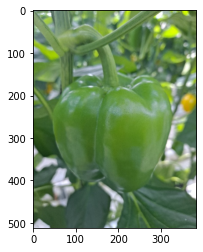

In [6]:
# 플젝 데이터셋에서 데이터 불러와 확인을 위한 테스트 부분임 : 이미지 파일 확인

image_sample = cv2.imread(train_images[1])

plt.imshow(cv2.cvtColor(image_sample, cv2.COLOR_BGR2RGB))
plt.show()

In [7]:
# 플젝 데이터셋에서 데이터 불러와 확인을 위한 테스트 부분임 : json파일 확인

with open(train_annots[1], "r") as f:
    annot_sample = json.load(f)

print(annot_sample)
print(annot_sample['annotations']['bbox'])

{'description': {'date': '20210624', 'image': '10043.jpg', 'task': 0, 'width': 384, 'time': '1332', 'region': 0, 'height': 512}, 'annotations': {'area': 1, 'disease': '00', 'grow': 13, 'bbox': [{'x': 55.17857142857143, 'h': 271.60714285714283, 'y': 116.78571428571429, 'w': 272.14285714285717}], 'part': [], 'risk': 0, 'crop': 3, 'label': '3_00_0'}}
[{'x': 55.17857142857143, 'h': 271.60714285714283, 'y': 116.78571428571429, 'w': 272.14285714285717}]


### S1-2.바운딩박스 확인
* 플젝 baseline 코드에서 바운딩박스를 쳐주는 코드 발췌해 온 것임

{'x': 55.17857142857143, 'h': 271.60714285714283, 'y': 116.78571428571429, 'w': 272.14285714285717}


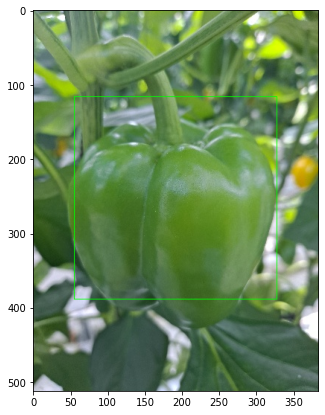

In [8]:
# 플젝 baseline 코드에서 바운딩박스를 쳐주는 코드 발췌해 온 것임
# visualize bbox
plt.figure(figsize=(7,7))
points = annot_sample['annotations']['bbox'][0]
print(points)
part_points = annot_sample['annotations']['part']
img = cv2.cvtColor(image_sample, cv2.COLOR_BGR2RGB)

cv2.rectangle(
    img,
    (int(points['x']), int(points['y'])),
    (int((points['x']+points['w'])), int((points['y']+points['h']))),
    (0, 255, 0),
)
for part_point in part_points:
    point = part_point
    cv2.rectangle(
        img,
        (int(point['x']), int(point['y'])),
        (int((point['x']+point['w'])), int((point['y']+point['h']))),
        (255, 0, 0),
        1
    )
plt.imshow(img)
plt.show()

## STEP 2. 데이터 전처리

### S2-1. label 만들기
* annotations 정보에 포함된 crop(작물), disease(병해), risk(진척상태) 데이터를 합쳐서 label로 사용할 코드를 생성해 주고
* 코드에서 label을 활용하기 위한 Encoder와 Decoder를 만들어 줌

In [9]:
# label 생성을 위해 개별 항목에 대한 코드(딕셔너리)화 작업.
# 변수 설명 csv 파일 참조

crop = {'1':'딸기','2':'토마토','3':'파프리카','4':'오이','5':'고추','6':'시설포도'}

disease = {'1':{'a1':'딸기잿빛곰팡이병','a2':'딸기흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '2':{'a5':'토마토흰가루병','a6':'토마토잿빛곰팡이병','b2':'열과','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '3':{'a9':'파프리카흰가루병','a10':'파프리카잘록병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '4':{'a3':'오이노균병','a4':'오이흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '5':{'a7':'고추탄저병','a8':'고추흰가루병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '6':{'a11':'시설포도탄저병','a12':'시설포도노균병','b4':'일소피해','b5':'축과병'}}

risk = {'1':'초기','2':'중기','3':'말기'}

In [10]:
# label 생성 : 개별 항목에 대한 코드를 이용해 '작물_병해_진행단계' 형식으로 label 생성

label_description = {}
for key, value in disease.items():
    label_description[f'{key}_00_0'] = f'{crop[key]}_정상'
    for disease_code in value:
        for risk_code in risk:
            label = f'{key}_{disease_code}_{risk_code}'
            label_description[label] = f'{crop[key]}_{disease[key][disease_code]}_{risk[risk_code]}'

# 클래스 갯수 확인  => 뒷 부분에서 num_classes 에 할당해 줌
print(len(label_description))

print(list(label_description.items())[:10])


111
[('1_00_0', '딸기_정상'), ('1_a1_1', '딸기_딸기잿빛곰팡이병_초기'), ('1_a1_2', '딸기_딸기잿빛곰팡이병_중기'), ('1_a1_3', '딸기_딸기잿빛곰팡이병_말기'), ('1_a2_1', '딸기_딸기흰가루병_초기'), ('1_a2_2', '딸기_딸기흰가루병_중기'), ('1_a2_3', '딸기_딸기흰가루병_말기'), ('1_b1_1', '딸기_냉해피해_초기'), ('1_b1_2', '딸기_냉해피해_중기'), ('1_b1_3', '딸기_냉해피해_말기')]


In [11]:
# label 생성 : 생성한 label를 처리할 때 사용할 수 있게 encoder, decoder를 만들어둠
 
label_encoder = {key:idx for idx, key in enumerate(label_description)}
label_decoder = {val:key for key, val in label_encoder.items()}

print(label_encoder['1_00_0'])
print(label_decoder[41])

0
3_00_0


### S2-2. json파일 읽어서 label항목을 만들어 추가해 줌
* 사전에 수행해 주었으므로 코드는 주석처리함.

In [12]:
# train_annot_list = glob.glob(train_path+'/annotations/*')
# val_annot_list = glob.glob(val_path+'/annotations/*')

In [13]:
# json파일에 있는 작물(crop), 병해(disease), 상태(risk) 정보를 파싱해서 
# label로 쓸 코드를 만들어 주는 코드 => 작업 완료

# for i, annot in enumerate(train_annot_list):

#     # if i == 10 :
#     #     break
#     with open(annot, "r") as file:
#         j_file = json.load(file)
#     # print(j_file)

#     label = str(j_file['annotations']['crop'])+"_"+str(j_file['annotations']['disease'])+"_"+str(j_file['annotations']['risk'])
#     print('i : ',i, ', label : ',label)
#     j_file['annotations']['label']=label 
#     # # j_file   
#     with open(annot, "w") as file:
#         json.dump(j_file, file)

# for i, annot in enumerate(val_annot_list):

#     # if i == 10 :
#     #     break
#     with open(annot, "r") as file:
#         j_file = json.load(file)
#     # print(j_file)

#     label = str(j_file['annotations']['crop'])+"_"+str(j_file['annotations']['disease'])+"_"+str(j_file['annotations']['risk'])
#     print('i : ',i, ', label : ',label)
#     j_file['annotations']['label']=label 
#     # # j_file   
#     with open(annot, "w") as file:
#         json.dump(j_file, file)


In [14]:
# # json파일 열어보기

# with open(train_path+'/annotations/58464.json', "r") as file:
#     sample = json.load(file)
# sample

In [15]:
# # 병해객체 바운딩박스 인덱싱 확인

# print(sample['annotations']['bbox'][0]['x'])

In [16]:
# # 병징(part) 바운딩박스 인덱싱 확인

# print(sample['annotations']['part'][0]['x'])

## STEP 3. 주요 함수 정의


### S3-1. 커스텀 데이터셋 클래스를 위한 target 생성 함수

In [17]:
'''
함수 및 변수 동작 확인을 위한 코드임
'''

# file = train_annots[0]
# print(file)

# with open(file) as f:

#     # json파일을 읽어서 part
#     data = json.load(f)  # json파일을 읽어서

#     objects = data['annotations']['bbox'] # 검출된 객체(농작물 병해 부위) 
#     print("objects:",objects)

#     num_objects = len(data['annotations']['bbox'])  # bbox의 갯수는 1개
#     print("num_objects: ", num_objects)

#     # 대상 객체를 나타내는 boxes와 label
#     # 각 함수의 리턴값은 리스트 형태임
#     labels = []
#     boxes = []

#     for i, obj in enumerate(objects) :
#         print("i: ",i)
#         print("obj :", obj)
        
#         labels.append(generate_label(i)) 
#         boxes.append(generate_box(i))

'\n함수 및 변수 동작 확인을 위한 코드임\n'

In [18]:
# 바운딩박스를 위한 함수들 정의

# 병해 객체에 대한 바운딩박스를 쳐주는 함수. 병해 객체는 하나의 이미지에 한 개만 있음
def generate_box(obj):
    '''
    annotation 파일에서 객체 bouding box 좌표를 읽어서 리턴함
    사용하는 bbox좌표 형식은 (좌상x, 좌상y, 우하x, 우하y)
    '''
    width = float(obj['description']['width'])
    height = float(obj['description']['height'])

    xmin = float(obj['annotations']['bbox'][0]['x'])  #find('xmin').text)
    ymin = float(obj['annotations']['bbox'][0]['y'])  #find('ymin').text)
    xmax = float(obj['annotations']['bbox'][0]['x']) + float(obj['annotations']['bbox'][0]['w'])  #find('xmax').text)
    ymax = float(obj['annotations']['bbox'][0]['y']) + float(obj['annotations']['bbox'][0]['h'])  #find('ymax').text)

    if xmax > width :
        xmax = width
    if ymax > height :
        ymax = height

    return [xmin, ymin, xmax, ymax]  # 실수형 좌표값이 든 리스트

'''
병징 관련된 부분(part)은 일단 배제
* 주의사항 : part(병징)정보가 없는 경우도 꽤 있음...추후 코드 구현시 참고바람

# N개의 병징들에 대해 바운딩박스를 쳐주는 함수 : 추천 코드에 없는데 추가한 부분임
# N개의 병징들은 

def generate_pbox(obj,i):
    
    #annotation 파일에서 질병(part) bouding box 좌표를 읽어서 리턴함
    #사용하는 bbox좌표 형식은 (좌상x, 좌상y, 우하x, 우하y, id)
    
    
    xmin_p = float(obj['annotations']['part'][i]['x'])  #find('xmin').text)
    ymin_p = float(obj['annotations']['part'][i]['y'])  #find('ymin').text)
    xmax_p = float(obj['annotations']['part'][i]['x']) + float(obj['annotations']['part'][i]['w'])  #find('xmax').text)
    ymax_p = float(obj['annotations']['part'][i]['y']) + float(obj['annotations']['part'][i]['h'])  #find('ymax').text)
    # id_p   = obj['annotations']['part'][i]['id']

    return [xmin_p, ymin_p, xmax_p, ymax_p]

adjust_label = 1  # adjust_lable : ??? <= 이게 왜 필요할까요?
'''

# 레이블을 생성해 주는 함수. 병해를 나타내는 레이블은 하나의 이미지당 1개임
# 마스크 디텍션에서 레이블은 3가지 경우의 수가 있고 if문으로 처리하였으나
# 농작물 병해는 작물_병해_진행단계 를 조합하여 만들어진 135개의 레이블이 있어
# 이를 처리해 주기 위해 encoder, decoder로 만들어 활용함

def generate_label(obj):  
    '''
    마스크착용상태 읽어서 레이블(정상착용, 비정상착용, 미착용)을 숫자로 리턴
    => json파일의 annotations에 추가한 label에서 읽어와서 할당하고 리턴함
    '''
    # print("젠레이블에서 받은 obj: ",obj)
    label = obj['annotations']['label']

    # print("젠리이블에서 변환전 label: ",label)
    label = label_encoder[label]
    # print("젠에이블에서 변환된 label: ",label)

    return label  # 정수형으로 바뀐 레이블값(1~112)
    # return 0 + adjust_label

# 이 함수가 대회용 baseline 모델에는 없는 부분이므로 내용 파악 잘 해야함
def generate_target(file): ## 넘겨받는 매개변수는 label_path(json파일경로)
    '''
    generate_box(), generate_label()를 각각 호출해서 반환된 값을 딕셔너리에 저장해 반환
    html.parser()를 이용해 annotatin에 있는 내용을 불러와 타켓의 바운딩박스와 라벨에 추가함
    '''

    '''
    json파일을 읽어들여서
    한 개의 label과
    한 개의 대상객체 바운딩박스bbox와
    병해증상(part)의 갯수를 파악해서
        여러개의 병해증상 바운딩박스pbbox 를 리스트에 담은 후
    tensor에 할당하고
    target딕셔너리의 각 키값에 할당한 뒤
    리턴 
    '''


    with open(file) as f:

        # json파일을 읽어서 part
        data = json.load(f)  # json파일을 읽어서
        # print("data: ",data)
        '''
        # 추천 코드에서와 마찬가지로 객체(여기서는 병해작물)를 objects로 할당
        # 그런데...마스크 디텍션에 쓰는 xml에서는 각각의 object 리스트 안에 
        # label('name')과 bbox좌표 등의 정보가 포함되어 있기 때문에 objects를 
        # get_boxe()나 get_label()의 매개변수로 넘겨주는 형식을 취함. 
        # 단, for문을 사용해 i로 넘겨주고 함수에서는 obj로 받는데..
        # 이 때 obj는 object 리스트임

        # 그런데... 농작물병해데이터셋 json에서는..annotation 아래로 bbox와 
        # label(생성해 준) 정보가 있는 점이 다름... 따라서... objects를 json에서
        # 어떤 단위에서 잡아줄 지 주의해야 하고, 함수에서 받았을 때 파싱에 유의해야 함
        '''
        # objects 는 검출된 객체(농작물 병해 부위) => 병해는 이미지당 하나이지만 
        bboxes = data['annotations']['bbox'] # 검출된 bbox 즉, 객체(농작물 병해 부위) 
        

        '''
        일단 part에 대해 추가했던 이 부분도 배제

        # 마스크 디텍션 코드에서 objects 는 label이 붙는 검출된 다수의 마스크만을 의미하지만
        # 농작물 병해진단에서는 label이 붙는 객체는 1개이며, 대신 병징을 나타내는 여러개의 part로 구성됨
        num_part = len(data['annotations']['part'])  # objects(part)의 갯수를 할당해서 
        '''

        '''
        대신 추천코드에서 처럼 object(마스크 디텍션에서는 N개의 마스크)의 갯수를 찾아서 
        그 갯수만큼 처리해주는 방식으로 해 봄.. 병해는 이미지에 하나지만...
        '''

        num_bbox = len(data['annotations']['bbox'])  # bbox의 갯수는 1개

        # 대상 객체를 나타내는 boxes와 label
        # 각 함수의 리턴값은 리스트 형태임
        labels = []
        boxes = []

        '''
        마스크디텍션에서 xml 파일에는 N개의 마스크에 대한 annot 정보.. 즉, 레이블과 
        bbox좌표가 n개의 objects에 담겨져 있기 때문에 그 갯수를 확인한 뒤
        for 문을 돌려서 각각의 object에 담긴 bbox좌표와 label값을 labels,
        boxes리스트에 추가해 주는 식으로 담아냈지만

        농작물병해검출에서 json파일에는 병해 정보와 해당 label은 1개 밖에 없기
        때문에 for 문은 필요하지 않다.

        단, 추후에 병징을 나타내는 pbox를 활용하는 경우에는 for문을 활용해서
        pbox좌표와 label을 넘겨줘야 한다.
        '''

        labels.append(generate_label(data)) 
        boxes.append(generate_box(data))

        # for i, obj in enumerate(objects) :
        #     print("젠레이블, 젠박스에 넘기는 obj: ", obj)
            
        #     labels.append(generate_label(data)) 
        #     boxes.append(generate_box(data))

        '''
        # 병징을 나타내는 part들에 대한 좌표를 저장할 변수를 리스트로 선언해 주고
        pboxes = []

        # part(병징)의 수 만큼 for문을 돌려서 좌표를 구해서 pboxes리스트에 추가해줌
        for i in range(num_part):
            # labels.append(generate_label(i))
            # boxes.append(generate_box(i))
            pboxes.append(generate_pbox(data,i))
        '''
        # 저장된 labels, boxes, pboxes를 tensor로 저장
        # 일단, 원래 코드에 있는 데이터사이즈로 저장해 줌 => 이게 문젠가??
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        '''
        pboxes = torch.as_tensor(pboxes, dtype=torch.float32) 
        '''
        # 함수의 리턴값인 target에 패킹해줌
        target = {}
        target["boxes"] = boxes 
        target["labels"] = labels
        # 멘토님 추천 코드 : boxes.unsqueeze(dim=0) # (4) -> (N=1, 4)
        # 위에서 labels을 리스트로 선언해주고 함수에서 리턴받은 리스트값을 추가해 줌
        '''
        target["pboxes"] = pboxes
        '''
        print("target:", target)
        print("type(target): ", type(target))

        return target  # labels과 boxes값들을 tensor값을 담은 딕셔너리 형태로 반환



### S3-2. 이미지 및 바운딩 박스 그려주는 함수 정의

In [19]:
# 매개변수 img는 tensor, annotation은 dic 타입의 값으로 받음

def plot_image_from_output(img, annotation):
    '''
    기존 마스크검출 코드의 내용임.
    이미지와 바운딩박스 함께 시각화
    마스크 착용시 green, 미 착용시 red, 잘못 착용시 orange
    
    데이터 탐색에서의 plot_image()는 이미지를 파일경로에서 읽어오지만
    plot_image_from_output()은 torch.tensor로 변환된 이미지를 시각화함
    '''
    
    # img = mping.imread(img_path) 
  
    # FRCNN 코드
    img = img.cpu().permute(1,2,0)  # tensor니까 계산을 위해서 cpu로 옮겨주고

    # dpp maskdetection 추천코드
    # img = img.permute(1,2,0)  # tensor니까 계산을 위해서 cpu로 옮겨주고..가 없음

    '''
    pytorch에서는 이미지를 [channel, height, width]형식으로 표현하는 반면
    matplotlib에서는 [height, width, channel]형식으로 표현하므로
    채널 순서를 바꿔주는 permute()함수를 활용해서 matplotlib에서 사용하기 위해
    채널 순서를 바꿔줌
    '''

    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    '''
    annotation에서 bbox 좌표를 받아서 대상객체 바운딩 박스를 그려준다.
    '''
    for idx in range(len(annotation["boxes"])):

        # 9/25 멘토링 부분임
        '''
        좌표값들은 rectangle()에 넣어서 그려주게 되는데 이 rectangle()은
        tensor의 형태로 사용할 수 없기 때문에 numpy로 바꿔줘야 하는데
        annotation은 tensor에 담겨서 GPU에 올려져 있기 때문에 
        여기서 떼어내 줘야 하므로 cpu().detatch().numpy()로 이를 처리해줘야 함

        처음엔 xmin, ymin, xmax, ymax = annotations['boxes'][idx].cpu() 로 해줘서
        해결된듯 했지만 detatch해주지 않으면 언제고 문제가 될 수 있었던 것임.
        '''
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        # xmin = torch.as_tensor(xmin).cpu().detach().numpy()
        # ymin = torch.as_tensor(ymin).cpu().detach().numpy()
        # xmax = torch.as_tensor(xmax).cpu().detach().numpy()
        # ymax = torch.as_tensor(ymax).cpu().detach().numpy()  

        xmin = xmin.cpu().detach().numpy()
        ymin = ymin.cpu().detach().numpy()
        xmax = xmax.cpu().detach().numpy()
        ymax = ymax.cpu().detach().numpy()  

        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=2,edgecolor='r',facecolor='none')
  
        ax.add_patch(rect)
    # ??? add_patch() 함수는 좌상x, 좌상y, h, w를 좌표로 해서 그림을 그려주는데...???
    # 아항.. w, h를 각각 Xmax - Xmin, Ymax-Ymin 으로 환산해서 값을 구해 적용해 주네 ㅋ
    # 그러면.. 애초에 json에서는 x, y, h, w로 좌표가 주어지니까 굳이 환산할 필요가 없네 ㅠㅠ
    # 요 부분은 나중에 ㅋ
    '''
    annotation에서 pbox들의 좌표를 받아서 여러개의 병해부위 바운딩 박스를 그려준다
    '''

    # for idx in range(len(annotation["pboxes"])):
    #     xmin, ymin, xmax, ymax = annotation["pboxes"][idx].cpu()  
    #         # .cpu()를 해주지 않으면 tensor관련 에러가 발생함

    #     rect_p = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')
        
    #     ax.add_patch(rect_p)

    plt.show()

## STEP 4. 데이터셋 클래스와 데이터 로더 정의

* 파이토치 모델을 학습시키기 위해서 데이터셋 클래스를 정의해야 함

* torchvision에서 제공하는 객체탐지모델을 학습시키기 위한 데이터셋클래스의 __getitem__메서드는 이미지 파일과 바운딩박스 좌표를 반환함

* 최종적으로 훈련용 데이터와 시험용 데이터를 batch단위로 불러올 수 있게 torch.utils.data.DataLoader함수를 활용해 data_loader와 val_data_loader를 각각 정의함

* torch.utils.data.DataLoader() 함수를 통해 배치 사이즈를 4로 지정해 불러옴
* 배치 사이즈는 개인의 메모리 크기에 따라 자유롭게 설정하면 됨

### S4-1. 커스텀데이터셋 클래스 및 데이터 로더 정의 : transform 적용 - 기본 

In [20]:
# Albumentation 최신 버전 설치

# ! pip install albumentations==0.5.2.
import albumentations as A

target: {'boxes': tensor([[ 55.1786, 116.7857, 327.3214, 388.3929]]), 'labels': tensor([41])}
type(target):  <class 'dict'>


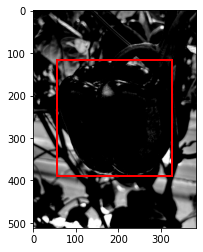

train_data_loader:  <torch.utils.data.dataloader.DataLoader object at 0x7f9edc88dcd0>


In [21]:
from IPython.core.interactiveshell import default_banner

class CropDiseaseDataset(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # transform module과 img path 경로를 정의
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        # print(self.path)
        # print(self.imgs)

    def __len__(self): 
        return len(self.imgs)

    def __getitem__(self, idx): #special method
        # load images ad masks
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'json'
        img_path = os.path.join(self.path, file_image)
        
        if 'val' in self.path:
            label_path = os.path.join(val_path+"/annotations/", file_label)
        else:
            label_path = os.path.join(train_path+"/annotations/", file_label)

        # # 이 부분이 이미지 augmentation에 적용하는 내용과 다른 부분임.

        # '''
        # 기본 코드에서는 컬러컨버트 해 주는 방법도 살짝 다름
        # img = Image.open(img_path).convert("RGG") # 같은 내용인데 한 줄로 ㅎㅎ
        # '''
        # # Read an image with OpenCV
        # img = cv2.imread(img_path)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # target = generate_target(label_path)
        # print("nott_target: ",target)
        

        # '''
        # self.tranform 이 False가 아니면.. __init__에서 self.transform = transform으로 할당해 줬음
        # img와 bboxes와 labels을 transform에 줘서 전치리한 값을 각각 transformed 딕셔너리로 받은 후에
        # 각각 image와 딕셔너리인 target...즉 boxes, labels로 할당해 줘서
        # image와 target으로 반환함
        # '''

        # # if self.transforms is not None:
        #     '''
        #     기본 코드에서는 img에 대해서만 transform을 적용했고 그 내용은 단순히 tensor로 덮어주는것
        #     그렇지만 box_aug를 해 주기 때문에 여기서는 bboxes와 labels에 대한 것도 transform에서 받아서
        #     target에 반영해주었음
        #     '''
        #     # transformed = self.transforms(img = img, bboxes = target['boxes'], labels = target['labels'])
 
        #     # img = transformed['imgs']
        #     # target = {'boxes':transformed['bboxes'], 'labels':transformed['labels']}

        ## 이 부분은 transform에 단지 ToTensor()만 적용한 기본 코드 내용 ###

        img = Image.open(img_path).convert("RGB")

        # Generate Target : 매개변수는 label_path.. 즉, json파일 경로
        # 여기서 리턴받은 target(즉 그 안에 들어있는 label과 box값은 tensor)
        target = generate_target(label_path)

        if self.transforms is not None:  # 이미지는 tranforms 있으면 그 적용결과
            img = self.transforms(img)

        #### 여기까지 임 ####################################################


        # print(img.shape)
        # print(target.shape)

        return img, target

# 성능개선을 위한 transform 정의
# transforms.Compose : list 내의 작업을 연달아 할 수 있게 호출하는 클래스
'''
추후에 데이터전처리와 관련된 작업 내용을 Compose에 추가해야 함
'''
# 기본 data_transform

data_transform1 = transforms.Compose([
        # # A.HorizontalFlip(p=1),
        # # A.Rotate(p=1),
        # A.ColorJitter(brightness=0.5, contrast=0.5, hue=0.5),  # 밝기 대비 채도 수정
        # A.RandomBrightnessContrast(brightness_limit=(-0.3, 0.3)),  # 픽셀단위 밝기와 대비 변경
        # A.HueSaturationValue(p=1),  
        # A.RGBShift(p=1),
        # # A.ChannelShift(p=1),
        # A.GaussNoise(p=1),
        # A.Cutout(p=1, num_holes=8, max_h_size=24, max_w_size=24),
        # A.MotionBlur(p=1, image=img),
        # A.RandomBrightnessContrast(brightness_limit=1, contrast_limit=1, p=1.0),
        # A.OpticalDistortion(p=1),
        # A.Normalize(std=0.5, mean=0.5),
        # A.pytorch.transforms.ToTensorV2()
        transforms.Grayscale(num_output_channels=3),
        # transforms.GausianBlur(kernel_size=)
        transforms.ColorJitter(brightness=0, contrast=0, saturation=0),
        # transforms.LinearTensor(2,5),
        transforms.ToTensor(), # ToTensor : numpy 이미지에서 torch 이미지로 변경
        transforms.Normalize(mean=0.5, std=0.5)
    ])

# bbox augmentation 적용 transform

def collate_fn(batch):
    return tuple(zip(*batch))


train_dataset = CropDiseaseDataset(data_transform1, train_path+'/images/')
val_dataset = CropDiseaseDataset(data_transform1, val_path+'/images/')

img, annot = train_dataset[0]
plot_image_from_output(img, annot)

# 훈련용 데이터와 시험용 데이터를 batch단위로 불러올 수 있게 
# data_loader, val_data_loader를 각각 정의함
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, collate_fn=collate_fn)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=2, collate_fn=collate_fn)

print("train_data_loader: ", train_data_loader)

### S4-2. 커스텀 데이터셋 클래스 및 데이터 로더 정의 : transform - Bbox Augmentation 

In [22]:
# Albumentation 최신 버전 설치

# ! pip install albumentations==0.5.2.
# import albumentations 

In [23]:
# # 바운딩 박스 augmentation을 위한 새로운 데이터셋 클래스 생성

# class BboxAugmentationDataset(object):
#     '''
#     AlbumentationDataset클래스의 transform부분 수정
#     이미지 뿐만 아니라 바운딩박스도 transform이 진행되도록 필요한 입력값, 출력값 수정해줌
#     '''

#     def __init__(self, path, transform=None):  # __init__의 매개변수에서 transform이 None인데, 일반적인 경우 매개변수 transform을 그냥 받음
#         self.path = path
#         self.imgs = list(sorted(os.listdir(self.path)))
#         self.transform = transform  # 다시 self.transform에 transform을 할당해주는 의미?
        
#     def __len__(self):
#         return len(self.imgs)

#     def __getitem__(self, idx):
#         file_image = self.imgs[idx]
#         file_label = self.imgs[idx][:-3] + 'json'
#         img_path = os.path.join(self.path, file_image)

#         if 'val' in self.path:
#             label_path = os.path.join(val_path+"/annotations/", file_label)
#         else:
#             label_path = os.path.join(train_path+"/annotations/", file_label)
        
#         # Read an image with OpenCV
#         image = cv2.imread(img_path)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#         target = generate_target(label_path)
#         print("nott_target: ",target)
        
#         # 이 부분이 이미지 augmentation에 적용하는 내용과 다른 부분임.
#         '''
#         self.tranform 이 False가 아니면.. __init__에서 self.transform = transform으로 할당해 줬음
#         img와 bboxes와 labels을 transform에 줘서 전치리한 값을 각각 transformed 딕셔너리로 받은 후에
#         각각 image와 딕셔너리인 target...즉 boxes, labels로 할당해 줘서
#         image와 target으로 반환함
#         '''

#         if self.transform:
#             transformed = self.transform(image = image, bboxes = target['boxes'], labels = target['labels'])
#             image = transformed['image']

#             target = {'boxes':transformed['bboxes'], 'labels':transformed['labels']}

#             # # boxes를 tensor로 바꿔서 target에 할당해 주는 테스트 코드 ########
#             # t_bboxes = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)
#             # target = {'boxes':t_bboxes, 'labels':transformed['labels']}
#             # ###################################################################

#             print("target_image: ",image)
#             print("target_target: ",target)

#             # labels = torch.as_tensor(labels, dtype=torch.int64) 
#             # boxes = torch.as_tensor(boxes, dtype=torch.float32) 
#         return image, target

# # Compse() : 변환 정의 
# # 바운딩박스에 사용할 format을 파라미터로 정해줌
# '''
# 1) 좌우반전
# 2) -90~90사이의 회전
# 3) 바운딩박스 변환을 위해 bbox_params에 albumentation.BboxParams객체 입력해 줌
# 4) FaceMaskDetection데이터셋의 바운딩박스 표기법이 xmin, ymin, xmax, ymax로 되어 있고
# 이것은 pascal_voc 표기법과 같음 -> format 파라미터에 pascal_voc를 입력해 줌
# 5) transform진행 시 객체별 클래스 값은 labels파라미터에 저장하기 위해 label_field에 labels를 저장
# '''
# bbox_transform = albumentations.Compose(
#     [albumentations.HorizontalFlip(p=1),
#      albumentations.Rotate(p=1),
#      albumentations.Normalize(std=0.5, mean=0.5),  # 추천코드에서는 노멀라이즈가 포함되지 않았는데 상관없는지?
#      albumentations.pytorch.transforms.ToTensorV2()],
#     bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['labels']),
# )

# # BboxAugmentationDtataset 클래스를 활성화 해 augmentation 결과물 확인
# # 위 코드를 싱핼할 때마다 이미지도 변환되어 출력되고, 
# # 더불어 바운딩박스도 알맞게 변환되어 변환된 이미지에 있는 마스크 착용 얼굴들을 정확히 탐지
# train_Bboxdataset = BboxAugmentationDataset(
#     path = train_path+'/images/',
#     transform = bbox_transform
# )
# val_Bboxdataset = BboxAugmentationDataset(
#     path = val_path+'/images/',
#     transform = bbox_transform
# )

# # img, annot = bbox_transform_dataset[0]
# # print("(type(img): ",type(img))
# # print("(type(annot): ",type(annot))
# # print("annot: ",annot)

# # # label 값과 boxes값을 전달해서 bbox를 그려준다.
# # plot_image_from_output(img, annot)

# # def collate_fn(batch):
# #     return tuple(zip(*batch))

# # train_dataset = CropDiseaseDataset(data_transform1, train_path+'/images/')
# # val_dataset = CropDiseaseDataset(data_transform1, val_path+'/images/')

# # transpose 적용한 데이터셋으로 샘플을 하나 찍어봄. 이거를 실행하려면 위에서 
# img, annot = train_Bboxdataset[0]
# plot_image_from_output(img, annot)


# # 훈련용 데이터와 시험용 데이터를 batch단위로 불러올 수 있게 
# # data_loader, val_data_loader를 각각 정의함

# train_data_loader = torch.utils.data.DataLoader(train_Bboxdataset, batch_size=4, collate_fn=collate_fn)
# val_data_loader = torch.utils.data.DataLoader(val_Bboxdataset, batch_size=2, collate_fn=collate_fn)

# print("train_data_loader: ", train_data_loader)

## STEP 5. 모델 불러오기 : Faster R-CNN

* 기본 모델 개요
    * 이번 마스크 검출의 경우에 사용된 모델은 Faster R-CNN모델에 기반한 Mask R-CNN모델

    * Faster R-CNN모델은 이미지에 존재할 수 있는 객체에 대한 바운딩 박스와 클래스 점수를 모두 예측하는 모델

* 전이학습(미리 학습된 모델을 가지고 와서 사용:fasterrcnn_resnet50_fpn)
    * 첫번째, 미리 학습된 모델에서 시작해서 마지막 레이어 수준만 미세 조정하는 방법
    * 두번째, 모델의 백본을 다른 백본으로 교체하는 것. 일테면 더 빠른 예측을 하려고 할 때(예:ResNet101에서 MobilenetV2로 교체하면 수행 속도 향상 기대. 단, 인식 성능은 저하될 수 있음)

* torchvision에서는 각종 컴퓨터 비전 문제를 해결하기 위한 딥러닝모델을 쉽게 불러올 수 있는 API를 제공함.
* torchvision.model.detection에서는 Faster R-CNN API(torchvision.models.detection.fasterrcnn_resnet50_fpns)을 제공하고 있어 쉽게 구현이 가능 
* 이는 COCO데이터셋을 ResNet50기반으로 pre-trained한 모델을 제공하고 있으며, pretrained=True/False로 설정할 수 있음

* 이후 모델을 불러올 때는, 
* num_classes에 원하는 클래스 갯수를 설정하고 모델을 사용하면 됨
* Faster R-CNN 사용 시 주의할 점은, background 클래스를 포함한 갯수를 num_classes에 명시해주어야 함. -> 실제 데이터셋의 클래스 갯수에 1개를 더해 backgrond 클래스 갯수를 추가해 주어야 함

### S5-1. 모델 정의(전이 : pre-trained fasterrcnn_resnet50_fpn) 및 변형

In [24]:
# 모델 불러오는 함수 정의 : [retrain된 fasterrcnn_resnet50_fpn 모델
# 미리 학습된 모델로부터 특정 클래스를 위해 미세 조정 
def get_model_instance_segmentation(num_classes):
    # COCO로 미리 학습된 모델 할당
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # 분류기를 새로운 것으로 교체하는데, num_classes는 사용자가 정의해 줌
    # num_classes = 2  # 1 클래스(작물) + 배경

    # 분류기에 넣어줘서 사용할 입력 특징의 차원 정보(갯수)를 얻음
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # 마스크 예측기를(미리 학습된 모델의 머리 부분)을 새로운 것으로 교체함
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # 만일 모델을 일부 수정하려는 경우는 다음과 같이 사용함
    '''
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    hidden_layer = 256
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, hidden_layer, num_classes)
    '''
    
    return model

### S5-2. 모델 할당

* 플젝(농작물 병해 진단) 데이터셋은 111개(레이블 수)의 클래스로 이루어져 있지만, background 클래스를 포함해 num_classes를 112로 설정.
* GPU를 사용할 수 있는 환경이라면 device로 지정해 불러온 모델을 GPU에 보내줌

In [25]:
# get_model_instance_segmentation()으로 모델 불러옴. 파라미터 112는 클래스의 수

# 클래스 111개 + 배경 클래스 1개 = 112
print(len(label_description)+1)
num_classes = len(label_description)

model = get_model_instance_segmentation(num_classes)

# GPU를 사용할 수 있으면 모델을 GPU에 보내줌
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.to(device)

112


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [26]:
torch.cuda.is_available()

True

## STEP 6. 모델 학습

In [27]:
# 모델 학습. epoch지정해 주고, optimizer도 지정해 줌(여기선 SGD)

num_epochs = 5
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

In [28]:
# data_loader에서 한 배치씩 순서대로 모델에 사용하며, 이후 loss 계산을 통해 최적화 수행
# 각 epoch마다 출력되는 loss를 통해 학습이 진행되는 것을 확인할 수 있음

print('----------------------train start--------------------------')

for epoch in range(num_epochs):

    # 매 Epoch에 소요되는 시간 측정을 위해
    '''
    time.time()은 그 시점 시간이므로 작업 서두에 time.time()을 start로 설정해 놓고
    Epoch 끝부분에 time.time()을 찍어서 start에서 빼주면 소요시간이 산추뢴
    '''
    start = time.time()
    
    # 학습
    model.train()

    i = 0    
    epoch_loss = 0

    # 학습데이터 로더에서 image와 annot을 하나씩 꺼내서
    for imgs, annotations in train_data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)

        print("annotations: ", annotations)
        print("type(annotations): ",type(annotations))
        print(annotations[0])
        print(type(annotations[0]))
        print("x_max : ", annotations[0]['boxes'])
        print("annotations in train_data_loader : ",annotations)
        print("type(annotations): ",type(annotations))
        print("i: ",i)
        
        annotations = [{k: torch.as_tensor(v).to(device) for k, v in t.items()} for t in annotations]
        
        loss_dict = model(imgs, annotations) 
        losses = sum(loss for loss in loss_dict.values())        

        # 학습 최적화
        '''
        각 학습 단계에서 모델의 오류를 줄이기 이해 모델 매개변수를 조정하는 과정
        모든 최적화 절차는 optimizer 객체에 캡슐화됨. 
        옵티마이저에는 SGD, ADAM, RMSProp 등 모델과 데이터마다 잘 동작하는 다양한
        옵티마이저가 있으니 잘 선택해서 사용하면 됨.

        최적화의 세단계는
        1) optimizer.zero_grad()를 호출해 모델 매개변수의 변화도를 재설정.
        기본적으로 변화도는 더해지기(add up)때문에 중복 계산을 막기 위해
        반복할 때마다 명시적으로 0으로 설정함
        2) loss.backwards()를 호출해 예측손실(prediction loss)을 역전파함.
        파이토치는 각 매개변수에 대한 손실의 변화도를 저장함
        3) 변화도를 계산한 뒤에는 coptimizer.step()을 호출해 역전파 단계에서
        수집된 변화도로 매개변수를 조정함
        '''

        # gradients 초기화
        '''
        파이토치에서는 gradients값들을 추후에 backward(역전파)해 줄때 계속
        더해주기 때문에 우리는 항상 역전파시작 전에 gradients를 zero로 초기화 해줌

        역전파할 때 gradients를 더해주는 방식은 학습시에 매우 편리한 방식이므로
        loss.backward()를 호출할때 초기설정은 gradients를 매번 더해 주는 것으로 
        설정되어 있음 -> 학습 loop를 돌때 이상적으로 하습이 이루어지기 위해서는
        한번의 학습이 완료되어지면 즉, iteration이 한 번 끝나면, gradients를 항상
        0으로 만들어주어야 하며, 초기화해주지 않으면 gradient가 의도한 방향이랑 다른
        방향을 가르켜 학습이 원하는 방향으로 이루어 지지 않음 
        '''
        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 


        epoch_loss += losses

    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')


----------------------train start--------------------------
target: {'boxes': tensor([[ 55.1786, 116.7857, 327.3214, 388.3929]]), 'labels': tensor([41])}
type(target):  <class 'dict'>
target: {'boxes': tensor([[128.7995, 188.1020, 300.9607, 451.4447]]), 'labels': tensor([41])}
type(target):  <class 'dict'>
target: {'boxes': tensor([[ 42.8571, 146.2500, 327.8571, 430.1786]]), 'labels': tensor([41])}
type(target):  <class 'dict'>
target: {'boxes': tensor([[ 64.2851,  52.9024, 342.8596, 468.7552]]), 'labels': tensor([54])}
type(target):  <class 'dict'>
annotations:  ({'boxes': tensor([[ 55.1786, 116.7857, 327.3214, 388.3929]]), 'labels': tensor([41])}, {'boxes': tensor([[128.7995, 188.1020, 300.9607, 451.4447]]), 'labels': tensor([41])}, {'boxes': tensor([[ 42.8571, 146.2500, 327.8571, 430.1786]]), 'labels': tensor([41])}, {'boxes': tensor([[ 64.2851,  52.9024, 342.8596, 468.7552]]), 'labels': tensor([54])})
type(annotations):  <class 'tuple'>
{'boxes': tensor([[ 55.1786, 116.7857, 327.32

In [29]:
# torch.save() : 학습시킨 가중치를 저장해 두고 나중에 언제든지 불러와 사용
torch.save(model.state_dict(),f'model_{num_epochs}.pt')

In [30]:
# torch.load() : 저장해 놓은 학습된 가중치를 불러옴
model.load_state_dict(torch.load(f'model_{num_epochs}.pt'))

<All keys matched successfully>

## STEP 7. Inference
* 모델 학습이 끝났으면 잘 학습되었는지 예측 결과를 확인해 봄
* 예측결과에는 바운딩박스의 좌표(bbox)와 클래스(label), 점수(scores)가 포함됨
* 점수(scores)에는 해당 클래스의 신뢰도 값이 저장되는데..
* make_prediction : treshhold값이 0.5이상인 것만 추출하도록 설정해주는 파라미터
* val_data_loader의 첫번째 배치에 대해서만 결과 출력

In [31]:
# inference 함수 정의

def make_prediction(model, img, threshold):
    
    # 모델을 추론모드로 바꿔줌 => Dropout, Batchnom 기능 비활성화
    model.eval()
    '''
    해당 모델의 모든 레이어가 evaluation mode에 들어가게 해 줌.
    즉, 학습할 때만 필요한 Dropout, Batchnorm 등 기능을 비활성화시켜줌
    추론할 때의 모드로 작동하도록 조정해주는 역할을 하며, 메모리와는 관련이 없음.
    '''
    
    # img를 넣어서 추론한 결과를 preds에 할당.. 모델은 label, box 그리고 socre(IoU값)를 반환함
    preds = model(img)

    # 추론할 결과의 길이 즉 예측한 바운딩박스와 레이블 전체 갯수에 대해서

    for id in range(len(preds)) :
 
        # trashold를 적용해서 기준 이상의 score인 bbox에 대한 index값만 리스트에 넣어서 넘김
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        # 9/25 멘토링 해당 부분임..근데 이건 내가 검증 위해 넣었던 부분이고만
        # for idx, x_max in enumerate(preds[id]['boxes']):
        #     print("x_max: ",x_max)

        # trashold보다 score가 높은 것들의 레이블과 box값들을 preds에 할당해주고
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]
        
        ''' 이 부분은 일단 배제
        preds[id]['pboxes'] = preds[id]['pboxes'][idx_list]
        ''' 
        
        print("preds: ",preds)
        
    return preds

target: {'boxes': tensor([[ 89.1430, 162.0040, 254.1470, 399.8669]]), 'labels': tensor([54])}
type(target):  <class 'dict'>


target: {'boxes': tensor([[166.3647,   2.0927, 214.4963, 318.0872]]), 'labels': tensor([41])}
type(target):  <class 'dict'>
preds:  [{'boxes': tensor([[ 62.0526, 166.7233, 248.2198, 386.5498]], device='cuda:0',
       grad_fn=<IndexBackward0>), 'labels': tensor([41], device='cuda:0'), 'scores': tensor([0.4924], device='cuda:0', grad_fn=<IndexBackward0>)}, {'boxes': tensor([[ 39.5105, 234.0932, 310.7537, 462.7560],
        [  0.0000, 135.9594, 342.8205, 506.6350],
        [ 40.6067, 233.2491, 338.2570, 496.7191],
        [ 53.2384,  38.0783, 154.0796, 257.4270],
        [ 72.8877,  47.8401, 379.5945, 263.8379],
        [ 92.7636,   0.0000, 310.7382, 307.3242],
        [100.0172,  41.1458, 312.3039, 398.2932],
        [146.8824,  78.7044, 321.7083, 269.9900],
        [  7.8520,   0.0000, 379.6779, 397.0501],
        [144.3797,  37.1717, 222.4024, 262.9267],
        [ 93.1023,   0.0000, 307.7975, 332.0352],
        [ 51.3048,  30.6918, 159.5992, 258.1214]], device='cuda:0',
       grad_fn

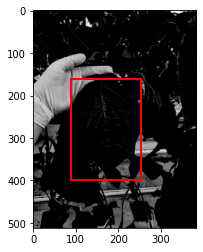

Target:  tensor([41])


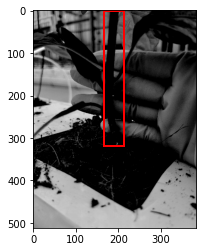

Prediction:  tensor([41], device='cuda:0')


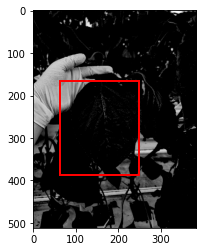

Prediction:  tensor([], device='cuda:0', dtype=torch.int64)


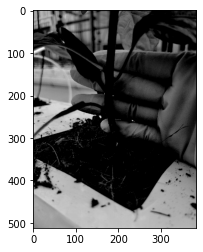

------------------------------------------------



In [32]:
for imgs, annotations in val_data_loader:
    imgs = list(img.to(device) for img in imgs)
    pred = make_prediction(model, imgs, 0.4)
    
    print('------------------------------------------------')

    # 기존 label 코드를 그대로 출력해 주는 코드임

    # 실제 바운딩 박스 위치
    for _idx in range(len(annotations)):
        print("Target: ", annotations[_idx]["labels"])
        plot_image_from_output(imgs[_idx], annotations[_idx])
    
    # 모델이 예측한 바운딩박스 위치 결과
    for _idx in range(len(pred)):
        print("Prediction: ", pred[_idx]["labels"])
        plot_image_from_output(imgs[_idx], pred[_idx])
    

    # label 코드를 라벨이름으로 바꿔서 출력해주는 코드임 => 9.26아침 추가 확인요

    # # 실제 바운딩 박스 위치
    # for _idx in range(len(annotations)):
    #     annot_label_cd = annotations[_idx]['labels'][0].item()
    #     annot_label = label_decoder[annot_label_cd]
    #     print("Target : ", label_description[annot_label])

    #     plot_image_from_output(imgs[_idx], annotations[_idx])

    # # 모델이 예측한 바운딩 박스 위치 결과
    # for _idx in range(len(pred)):
    #     pred_label_cd = pred[_idx]['labels'][0].item()
    #     pred_label = label_decoder[pred_label_cd]
    #     print("Prediction : ", label_description[pred_label])

    #     plot_image_from_output(imgs[_idx], pred[_idx])

    print('------------------------------------------------')
    print("")
    break

# # 9/25 멘토링에서 위 부분으로 대체시킨 부분임

# # torch.no_grad() : inference나 validation할 때 autograd engine(gradient계산 context)을 
# # 비활성화 해 줌으로써 더 이상 gradient를 트래킹하지 않게 됨 => 메모리 소요 감소, 연산속도 증가

# with torch.no_grad(): 
#     # 테스트셋 배치사이즈= 2
#     for imgs, annotations in val_data_loader:

#         # 이미지를 GPU로 옮겨주고 리스트형태로 만들어 imgs에 할당해 줌
#         imgs = list(img.to(device) for img in imgs)

#         # 모델과 imgs와 trashold를 줘서 추론하고 결과를 pred에 할당함
#         pred = make_prediction(model, imgs, 0.5)

#         print("val에 대한 pred: ",pred)
#         break

In [33]:
# # 예측된 결과를 이용해 이미지 위에 바운딩 박스를 그려봄
# # 위에서 정의한 plot_image_from_output()함수로 그림을 출력함
# # Target이 실제 바운딩 박스 위치,, Prediction이 모델이 예측한 결과
# # import random

# # index = [1, 2]
# # cnt = 0
# # for i in index:
# #     if cnt < 10:
# _idx = 1

# # 실제 바운딩 박스 위치
# print("Target : ", annotations[_idx]['labels'][0])
# plot_image_from_output(imgs[_idx], annotations[_idx])

# # 모델이 예측한 바운딩 박스 위치 결과
# print("Prediction : ", pred[_idx]['labels'][0])
# plot_image_from_output(imgs[_idx], pred[_idx])

## STEP 8. 평가
* 전체 시험 데이터에 대해 예측 결과를 평가해 봄


### S8-1. 모든 시험 데이터에 대한 예측 결과와 실제 label을 각각 preds_adj_all, annot_all에 담아줌

In [34]:
# 모든 시험 데이터에 대한 예측 결과와 실제 label을 
# 각각 preds_adj_all, annot_all에 담아줌

from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(val_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.4)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

  0%|          | 0/37 [00:00<?, ?it/s]

target: {'boxes': tensor([[ 89.1430, 162.0040, 254.1470, 399.8669]]), 'labels': tensor([54])}
type(target):  <class 'dict'>
target: {'boxes': tensor([[166.3647,   2.0927, 214.4963, 318.0872]]), 'labels': tensor([41])}
type(target):  <class 'dict'>


  3%|▎         | 1/37 [00:00<00:06,  5.95it/s]

preds:  [{'boxes': tensor([[ 62.0526, 166.7233, 248.2198, 386.5498]], device='cuda:0'), 'labels': tensor([41], device='cuda:0'), 'scores': tensor([0.4924], device='cuda:0')}, {'boxes': tensor([[ 39.5105, 234.0932, 310.7537, 462.7560],
        [  0.0000, 135.9594, 342.8205, 506.6350],
        [ 40.6067, 233.2491, 338.2570, 496.7191],
        [ 53.2384,  38.0783, 154.0796, 257.4270],
        [ 72.8877,  47.8401, 379.5945, 263.8379],
        [ 92.7636,   0.0000, 310.7382, 307.3242],
        [100.0172,  41.1458, 312.3039, 398.2932],
        [146.8824,  78.7044, 321.7083, 269.9900],
        [  7.8520,   0.0000, 379.6779, 397.0501],
        [144.3797,  37.1717, 222.4024, 262.9267],
        [ 93.1023,   0.0000, 307.7975, 332.0352],
        [ 51.3048,  30.6918, 159.5992, 258.1214]], device='cuda:0'), 'labels': tensor([41, 60, 98, 41, 41, 98, 41, 41, 60, 41, 60, 98], device='cuda:0'), 'scores': tensor([0.2072, 0.1610, 0.1365, 0.0989, 0.0943, 0.0932, 0.0876, 0.0770, 0.0753,
        0.0724, 0.060

  5%|▌         | 2/37 [00:02<00:45,  1.29s/it]

target: {'boxes': tensor([[100.4462, 125.8943, 259.8230, 463.3980]]), 'labels': tensor([95])}
type(target):  <class 'dict'>
preds:  [{'boxes': tensor([[ 59.9362,  92.1637, 324.3806, 345.9107]], device='cuda:0'), 'labels': tensor([41], device='cuda:0'), 'scores': tensor([0.4750], device='cuda:0')}, {'boxes': tensor([[103.2042,  99.3386, 255.1160, 409.5368],
        [ 25.8645,  51.5052, 292.3963, 481.2004],
        [ 36.7869,   0.0000, 257.0161, 462.5613],
        [  9.2676, 134.9950, 127.4081, 434.1828],
        [ 83.1350,  47.7625, 279.8727, 483.6140],
        [ 95.9587,  63.7223, 287.6983, 398.5847],
        [  0.0000, 111.3840, 332.6142, 418.9821],
        [ 91.3861,  96.6862, 287.8028, 375.6910],
        [ 45.9233, 122.1989, 374.7173, 380.4077],
        [ 51.3107,  12.5219, 302.0532, 466.5436],
        [ 89.1189,  93.1030, 279.3672, 369.8798],
        [120.4942, 135.3556, 285.0187, 506.1250],
        [  5.1047,  48.0477, 124.6940, 460.4537],
        [ 74.3756,  17.6052, 291.7388, 38

  8%|▊         | 3/37 [00:04<00:55,  1.63s/it]

target: {'boxes': tensor([[ 41.1146,   0.0000, 298.3953, 406.0776]]), 'labels': tensor([48])}
type(target):  <class 'dict'>
preds:  [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[ 66.8559,  96.2296, 269.2161, 436.0287],
        [ 39.8206,  38.6940, 277.5970, 308.7856],
        [  0.0000,   0.0000, 283.6734, 447.6540],
        [ 69.3957,   0.0000, 319.9799, 392.4188],
        [ 27.2799,   0.0000, 349.7491, 468.0139],
        [ 47.4992, 116.0161, 333.3328, 503.4171],
        [ 20.8178,  20.5364, 338.2769, 451.7424],
        [  1.9858,  14.6926, 354.5121, 242.0186],
        [ 89.3068,   0.0000, 283.3749, 323.3523],
        [ 56.3775,   0.0000, 288.4848, 286.9346],
        [ 49.7907,  38.7716, 294.4319, 417.2971]], device='cuda:0'), 'labels': tensor([41, 41, 60, 98, 41, 98, 54, 60, 60, 54, 89], device='cuda:0'), 'scores': tensor([0.4222, 0.3252, 0.3012, 0.2159, 0.2086,

 11%|█         | 4/37 [00:06<01:01,  1.85s/it]

target: {'boxes': tensor([[  1.9421,  92.2796, 241.3833, 414.2868]]), 'labels': tensor([43])}
type(target):  <class 'dict'>
preds:  [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[ 16.3144,  99.4660, 215.6434, 437.3224],
        [  0.0000,   0.0000, 227.6314, 512.0000],
        [ 10.3543,  48.0378, 234.4964, 287.2299],
        [ 14.9552,  26.0263, 240.3665, 420.0625],
        [ 12.2392, 185.1130, 240.7416, 503.0269],
        [ 27.6003, 193.2994, 181.5773, 489.8135],
        [  0.0000,  61.5343, 237.6989, 420.3968]], device='cuda:0'), 'labels': tensor([41, 60, 41, 98, 98, 41, 54], device='cuda:0'), 'scores': tensor([0.3879, 0.2432, 0.2081, 0.1727, 0.0762, 0.0718, 0.0695],
       device='cuda:0')}]
preds:  [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': ten

 14%|█▎        | 5/37 [00:08<01:01,  1.92s/it]

target: {'boxes': tensor([[159.0403, 239.4024, 328.9658, 440.2996]]), 'labels': tensor([0])}
type(target):  <class 'dict'>
preds:  [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[162.2845, 246.7415, 304.6727, 456.6941],
        [ 74.5911,  42.1535, 372.2787, 471.0221],
        [ 68.8828,  74.9469, 376.7388, 512.0000],
        [131.4418, 167.7299, 331.7725, 469.7119],
        [125.3485,  24.7598, 359.4370, 473.6622],
        [160.4749, 207.5098, 322.1223, 482.9371],
        [126.1419,  68.0572, 318.9120, 245.9986],
        [144.2836, 203.7165, 311.1952, 501.4359],
        [ 40.0419, 214.4173, 384.0000, 456.6331],
        [ 52.1382, 215.4655, 203.7457, 426.2085],
        [132.1679,  88.1083, 248.0060, 268.4886]], device='cuda:0'), 'labels': tensor([41, 41, 60, 41, 98, 98, 41, 60, 98, 41, 41], device='cuda:0'), 'scores': tensor([0.3057, 0.2378, 0.1677, 0.1525, 0.1331, 

 16%|█▌        | 6/37 [00:10<01:02,  2.00s/it]

target: {'boxes': tensor([[ 38.1688,  36.1611, 337.5025, 466.7463]]), 'labels': tensor([43])}
type(target):  <class 'dict'>
preds:  [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[ 40.8894, 125.3008, 328.8473, 451.9640],
        [  4.6161,   0.0000, 346.0128, 460.5780],
        [ 49.0592,  16.0084, 384.0000, 437.5732],
        [ 17.7856,  40.9394, 370.4147, 315.7306],
        [  0.0000,   0.0000, 263.1310, 494.4844],
        [ 41.3990, 174.0839, 340.8695, 512.0000],
        [ 52.4627, 202.6629, 328.2740, 512.0000],
        [  6.7278,  23.3000, 360.7533, 477.9364],
        [ 41.4171,  94.7266, 356.7462, 492.3031],
        [135.9921,  45.9851, 320.4071, 512.0000],
        [ 53.5525,   0.0000, 384.0000, 482.4514],
        [ 65.7266, 262.0822, 264.5422, 453.8101]], device='cuda:0'), 'labels': tensor([41, 60, 98, 41, 98, 60, 98, 54, 89, 98, 21, 41], device='cuda:0'), 'sc

 19%|█▉        | 7/37 [00:12<01:00,  2.03s/it]

target: {'boxes': tensor([[  3.7912, 114.0123, 205.5247, 286.4212]]), 'labels': tensor([0])}
type(target):  <class 'dict'>
preds:  [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[9.6182e+01, 2.3068e+02, 2.7734e+02, 4.5612e+02],
        [0.0000e+00, 1.2050e+02, 3.8133e+02, 5.1200e+02],
        [6.6582e+01, 1.1712e+02, 3.0854e+02, 4.6233e+02],
        [2.1227e+01, 1.3339e+02, 3.6515e+02, 4.6685e+02],
        [7.2051e+01, 5.3681e+01, 2.8078e+02, 4.5125e+02],
        [4.4905e-01, 4.2468e+01, 3.7800e+02, 4.8833e+02],
        [8.1624e+01, 2.4272e+02, 2.9963e+02, 4.1238e+02],
        [1.0638e+02, 2.1732e+02, 2.8199e+02, 4.7695e+02],
        [1.1122e+02, 2.8042e+02, 3.5910e+02, 4.9889e+02]], device='cuda:0'), 'labels': tensor([41, 60, 98, 41, 60, 98, 98, 60, 41], device='cuda:0'), 'scores': tensor([0.3176, 0.2612, 0.2163, 0.1770, 0.0808, 0.0782, 0.0597, 0.0512, 0.0503],
   

 22%|██▏       | 8/37 [00:14<01:00,  2.08s/it]

target: {'boxes': tensor([[ 76.2847,  23.1431, 295.4829, 451.1815]]), 'labels': tensor([48])}
type(target):  <class 'dict'>
preds:  [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[ 33.1307,  75.9336, 310.7110, 343.1648],
        [ 77.9475, 113.6907, 278.5254, 475.0246],
        [  0.0000,   0.0000, 384.0000, 444.8525],
        [102.1432,  22.2473, 336.4969, 418.9529],
        [ 35.5484,  71.9063, 302.4507, 507.1114],
        [ 53.9417,   0.0000, 306.9827, 331.4363],
        [ 12.4491,  65.3682,  90.5154, 459.3504],
        [ 67.7135,  86.1745, 284.4329, 512.0000],
        [ 42.2113,  54.6326, 319.4140, 398.8564],
        [ 45.8904,   0.0000, 291.4921, 313.1917],
        [ 45.1535,  85.2779, 307.0779, 512.0000],
        [149.6016, 193.3585, 367.8449, 469.3588],
        [107.1318,   0.0000, 378.4110, 479.7658]], device='cuda:0'), 'labels': tensor([41, 41, 60, 98, 98, 

 24%|██▍       | 9/37 [00:16<00:56,  2.03s/it]

target: {'boxes': tensor([[ 66.2941,  90.5148, 329.6922, 431.2548]]), 'labels': tensor([98])}
type(target):  <class 'dict'>
preds:  [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[ 55.1762, 207.3163, 318.1804, 436.6521],
        [  0.0000, 122.3029, 372.4196, 512.0000],
        [143.2959, 230.7323, 260.8579, 461.4031],
        [ 99.7728, 159.9449, 326.1948, 450.1945],
        [ 27.1618, 105.1412, 369.7072, 468.2076],
        [ 84.2287, 203.2062, 186.3424, 439.6826],
        [  0.0000,  65.9590, 324.0442, 484.4107],
        [ 48.9158, 137.9569, 311.5815, 412.1927],
        [ 47.3396,  97.3488, 237.4128, 263.4797],
        [ 26.0540, 225.3460, 384.0000, 512.0000],
        [ 45.0749,  79.8319, 244.4486, 257.4390],
        [ 17.9780,  42.2543, 369.1918, 487.7528],
        [ 61.0017, 189.1085, 352.4293, 436.6770],
        [123.9014, 218.9171, 286.3212, 450.4088]], device

 27%|██▋       | 10/37 [00:19<00:56,  2.10s/it]

target: {'boxes': tensor([[ 80.8320,  83.7200, 336.0335, 440.5403]]), 'labels': tensor([41])}
type(target):  <class 'dict'>
preds:  [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[ 65.3812, 112.0317, 329.8412, 355.3384],
        [  6.0816,  32.6100, 384.0000, 512.0000],
        [ 44.9207,  55.0627, 367.2930, 463.9246],
        [ 84.1613, 101.4390, 353.0878, 483.9660],
        [ 60.9556,  46.2720, 317.1216, 366.1634],
        [ 43.7673,   0.0000, 327.1304, 375.8530],
        [111.1536, 169.2401, 297.2253, 432.2798],
        [ 62.5456,  48.2578, 384.0000, 367.1168],
        [103.0012, 125.6976, 326.3163, 512.0000],
        [104.7845, 103.3909, 331.2098, 473.6873],
        [ 39.5759,  20.0038, 381.0365, 372.4171]], device='cuda:0'), 'labels': tensor([41, 60, 41, 98, 60, 98, 41, 54, 60, 89, 21], device='cuda:0'), 'scores': tensor([0.5503, 0.2981, 0.2558, 0.2523, 0.1224,

 30%|██▉       | 11/37 [00:21<00:53,  2.07s/it]

target: {'boxes': tensor([[174.1045,  47.6202, 663.6998, 485.1310]]), 'labels': tensor([60])}
type(target):  <class 'dict'>
preds:  [{'boxes': tensor([[132.9793, 258.5294, 373.6853, 488.6219]], device='cuda:0'), 'labels': tensor([41], device='cuda:0'), 'scores': tensor([0.4565], device='cuda:0')}, {'boxes': tensor([[168.7910,  87.1249, 673.4901, 425.2378],
        [110.1040,   0.0000, 669.7560, 452.2391],
        [286.3416,  69.1132, 591.1653, 512.0000],
        [276.4283,  60.8281, 682.0000, 512.0000],
        [ 41.1668,   0.0000, 578.6645, 458.7145],
        [119.6173,  75.0597, 433.3037, 512.0000],
        [149.3828,  80.8921, 427.0356, 472.5345],
        [126.8421,  66.8318, 413.6573, 497.2403],
        [330.7440, 113.6888, 499.9397, 428.9905],
        [155.1798,  35.2791, 626.1431, 483.4900]], device='cuda:0'), 'labels': tensor([41, 60, 60, 98, 98, 60, 41, 98, 41, 54], device='cuda:0'), 'scores': tensor([0.3728, 0.3125, 0.2227, 0.2114, 0.1535, 0.1158, 0.1126, 0.0927, 0.0628,
     

 32%|███▏      | 12/37 [00:23<00:51,  2.06s/it]

target: {'boxes': tensor([[ 87.8892,  22.6009, 291.2976, 467.0859]]), 'labels': tensor([48])}
type(target):  <class 'dict'>
preds:  [{'boxes': tensor([[ 88.8953,  51.1570, 308.4193, 450.9515]], device='cuda:0'), 'labels': tensor([41], device='cuda:0'), 'scores': tensor([0.4811], device='cuda:0')}, {'boxes': tensor([[ 62.2732,  81.1108, 277.0710, 461.7269],
        [  0.0000,   0.0000, 298.2598, 451.7840],
        [ 37.1605,  38.5655, 301.0205, 294.2570],
        [ 46.7289,  16.4639, 362.1932, 409.6945],
        [ 53.1728, 131.4736, 318.2256, 512.0000],
        [  0.0000,   0.0000, 241.2688, 498.5363],
        [ 23.5940,  34.5505, 335.2219, 386.5764],
        [ 75.3265, 117.8770, 263.3484, 512.0000],
        [ 84.7048,   0.0000, 262.3585, 336.7644],
        [105.2321, 236.7088, 235.5659, 468.8715],
        [ 62.5430, 121.3366, 319.3560, 512.0000],
        [102.0008,   0.0000, 280.9532, 443.7003],
        [ 91.3522,   0.0000, 294.4112, 472.4346],
        [257.5530,  25.0573, 334.8871, 26

 35%|███▌      | 13/37 [00:25<00:49,  2.08s/it]

target: {'boxes': tensor([[ 63.5272,   0.0000, 334.2726, 501.1164]]), 'labels': tensor([44])}
type(target):  <class 'dict'>
preds:  [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[ 80.4957,  50.3036, 315.8139, 439.1129],
        [ 56.2359, 214.5442, 305.1149, 482.5399],
        [ 39.7003,   5.0142, 271.5383, 512.0000],
        [ 81.0340,   0.0000, 327.5499, 418.3546],
        [ 85.3102,   0.0000, 333.4146, 322.6823],
        [ 68.1552, 153.9891, 290.4755, 512.0000],
        [103.4937, 144.8191, 284.2240, 395.9385],
        [ 33.7146,  31.5859, 365.4632, 268.4806],
        [ 94.6817, 279.0748, 245.8295, 481.1921],
        [ 50.3566,  13.2167, 352.1713, 454.2310],
        [ 16.3239,  24.3577, 350.0826, 271.9016],
        [ 97.1280, 141.4884, 310.1535, 502.6547],
        [ 86.8439,   0.0000, 326.1539, 462.8694]], device='cuda:0'), 'labels': tensor([41, 41, 60, 98, 60, 

 38%|███▊      | 14/37 [00:27<00:48,  2.10s/it]

target: {'boxes': tensor([[ 86.4000, 214.4914, 281.1429, 408.4286]]), 'labels': tensor([0])}
type(target):  <class 'dict'>
preds:  [{'boxes': tensor([[ 74.6365,   0.0000, 622.2977, 512.0000]], device='cuda:0'), 'labels': tensor([60], device='cuda:0'), 'scores': tensor([0.4780], device='cuda:0')}, {'boxes': tensor([[ 91.6173, 202.5142, 252.9217, 423.3865],
        [ 51.5176, 147.4104, 295.4954, 387.7609],
        [  0.0000, 122.8342, 384.0000, 512.0000],
        [ 66.4453, 152.1794, 282.9211, 450.1082],
        [  3.7326,  67.2848, 354.6411, 451.1952],
        [  0.0000,  52.7147, 327.6575, 464.4452],
        [ 49.3558, 113.0409, 281.3413, 408.6349],
        [ 82.4633, 230.2467, 273.0873, 399.3113],
        [ 84.3050, 120.5499, 384.0000, 512.0000],
        [  0.0000, 175.4532, 340.8286, 384.0079],
        [108.5204, 156.8976, 250.7611, 496.1855],
        [ 32.5251, 169.7274, 301.5273, 420.2993],
        [ 77.2607, 230.5421, 275.8958, 389.0989],
        [ 57.9917,  90.3596, 289.6557, 446

 41%|████      | 15/37 [00:29<00:46,  2.10s/it]

target: {'boxes': tensor([[105.4692,  87.0539, 291.2959, 469.5891]]), 'labels': tensor([89])}
type(target):  <class 'dict'>
preds:  [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[104.7218, 109.7471, 277.5116, 440.1782],
        [ 15.2480,  20.3696, 384.0000, 512.0000],
        [ 21.5359, 130.4170, 319.9293, 491.2097],
        [131.3225,  47.7189, 302.6830, 508.5032],
        [ 79.6771,  69.6936, 384.0000, 433.8607],
        [ 74.6158, 115.6983, 282.8052, 512.0000],
        [  0.0000, 170.2046, 311.3814, 512.0000],
        [ 14.5117, 172.3681, 163.9858, 391.0801],
        [ 51.2329, 117.3517, 317.4248, 401.5312],
        [113.9628, 132.9194, 281.8512, 500.0593],
        [  0.0000, 136.9095, 368.0938, 397.6805],
        [ 56.9317,   0.0000, 236.8750, 441.6104],
        [ 81.0613,   0.0000, 333.9090, 388.7792],
        [ 25.6432,   0.0000, 363.5770, 481.0911],
       

 43%|████▎     | 16/37 [00:31<00:43,  2.06s/it]

target: {'boxes': tensor([[104.6857,  93.0286, 292.3429, 433.3715]]), 'labels': tensor([51])}
type(target):  <class 'dict'>
preds:  [{'boxes': tensor([[  0.0000,   0.0000, 590.5829, 492.3908]], device='cuda:0'), 'labels': tensor([60], device='cuda:0'), 'scores': tensor([0.4031], device='cuda:0')}, {'boxes': tensor([[ 75.4775, 133.8644, 321.2031, 403.6663],
        [ 16.0583,  81.8053, 318.5272, 512.0000],
        [ 92.1064, 186.4547, 256.5620, 479.6825],
        [106.3010,  45.5136, 341.6542, 437.6571],
        [ 36.9091,  60.2161, 372.4917, 492.6656],
        [ 88.7567, 135.1109, 269.1201, 504.3470],
        [ 43.5166, 195.3213, 368.1234, 500.2304],
        [115.5758,  65.7846, 274.9908, 418.1906],
        [ 15.7773, 240.0393, 100.3791, 497.5165],
        [ 76.6103,  66.8336, 311.8202, 446.8174],
        [ 10.5033, 265.0153, 276.7124, 506.2658],
        [241.6058,  36.2451, 348.7916, 262.6374],
        [103.6024,   0.0000, 340.2664, 504.3910],
        [ 97.1343, 146.6024, 265.2633, 51

 46%|████▌     | 17/37 [00:33<00:42,  2.11s/it]

target: {'boxes': tensor([[112.3798,  57.1435, 574.2899, 445.7195]]), 'labels': tensor([98])}
type(target):  <class 'dict'>
preds:  [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[ 63.8433, 107.2975, 512.6977, 414.6454],
        [  0.0000,   0.0000, 625.1778, 482.8359],
        [ 45.8337,  30.6580, 535.7883, 461.6403],
        [257.3255,   0.0000, 588.1743, 464.2114],
        [149.0203,  55.5780, 459.4315, 509.5745],
        [233.6894,  19.9945, 561.5556, 362.6512],
        [230.8428,   0.0000, 544.9155, 370.9563],
        [142.4572,   0.0000, 616.5355, 512.0000]], device='cuda:0'), 'labels': tensor([41, 60, 98, 98, 60, 41, 60, 21], device='cuda:0'), 'scores': tensor([0.2997, 0.2668, 0.2521, 0.1326, 0.1082, 0.1019, 0.0828, 0.0520],
       device='cuda:0')}]
preds:  [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch

 49%|████▊     | 18/37 [00:35<00:40,  2.16s/it]

target: {'boxes': tensor([[  0.0000,  87.6238, 357.9476, 477.5243]]), 'labels': tensor([0])}
type(target):  <class 'dict'>
preds:  [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[  0.0000,  30.6910, 384.0000, 512.0000],
        [ 34.0793, 121.7707, 334.2621, 471.7011],
        [ 49.3033,   4.8548, 372.7510, 485.0898],
        [ 33.6049,  33.2124, 327.8015, 316.2301],
        [  0.0000,  25.2372, 363.3257, 458.5936],
        [ 31.7717,   0.0000, 330.3840, 327.1572]], device='cuda:0'), 'labels': tensor([60, 41, 98, 41, 54, 60], device='cuda:0'), 'scores': tensor([0.4693, 0.4464, 0.2179, 0.0844, 0.0586, 0.0520], device='cuda:0')}]
preds:  [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[  0.0000,  30.6910, 384.0000, 512.0000],
        [ 34.0793, 121.

 51%|█████▏    | 19/37 [00:38<00:38,  2.14s/it]

target: {'boxes': tensor([[154.3534,   0.0000, 208.7621, 308.0370]]), 'labels': tensor([41])}
type(target):  <class 'dict'>
preds:  [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[139.8362,  73.0320, 252.4745, 294.8802],
        [ 62.4893,   2.4701, 366.4144, 357.7101],
        [132.0418,  51.5404, 320.8482, 246.4860],
        [  0.0000,   0.0000, 365.9665, 338.7424],
        [ 31.3292, 148.2855, 358.7718, 498.7595],
        [ 50.8484,   0.0000, 382.3525, 366.6058],
        [163.1429,  86.7326, 361.8844, 387.5845]], device='cuda:0'), 'labels': tensor([41, 41, 41, 60, 41, 98, 41], device='cuda:0'), 'scores': tensor([0.0947, 0.0946, 0.0712, 0.0695, 0.0674, 0.0607, 0.0545],
       device='cuda:0')}]
preds:  [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': ten

 54%|█████▍    | 20/37 [00:40<00:35,  2.07s/it]

target: {'boxes': tensor([[120.9596, 103.4063, 293.2120, 429.8081]]), 'labels': tensor([41])}
type(target):  <class 'dict'>
preds:  [{'boxes': tensor([[115.0828, 200.6783, 300.2059, 372.2968]], device='cuda:0'), 'labels': tensor([41], device='cuda:0'), 'scores': tensor([0.4096], device='cuda:0')}, {'boxes': tensor([[128.4541, 128.0043, 269.1357, 395.8160],
        [ 65.6852, 117.7106, 326.9401, 343.6898],
        [116.3040,  70.6296, 359.6517, 472.1932],
        [128.0340,  89.4084, 273.7659, 366.4563],
        [ 18.5942,   5.7391, 369.2111, 371.0903],
        [120.5488,  74.0050, 384.0000, 483.5432],
        [ 62.2068,  53.0402, 266.3375, 512.0000],
        [ 68.4920, 158.9044, 384.0000, 378.8741],
        [110.1156, 127.0414, 356.0065, 512.0000],
        [119.5974,  59.9703, 308.1723, 347.1960],
        [ 48.4841,  47.0731, 308.7223, 442.3700],
        [138.3551, 113.1434, 263.0436, 428.6582],
        [119.9538, 142.8453, 288.9739, 376.4716],
        [114.4998, 222.2258, 253.8701, 42

 57%|█████▋    | 21/37 [00:41<00:32,  2.01s/it]

target: {'boxes': tensor([[ 71.4332, 117.6224, 289.4349, 454.4782]]), 'labels': tensor([41])}
type(target):  <class 'dict'>
preds:  [{'boxes': tensor([[ 71.9205, 220.3361, 295.7460, 483.1199]], device='cuda:0'), 'labels': tensor([41], device='cuda:0'), 'scores': tensor([0.4050], device='cuda:0')}, {'boxes': tensor([[ 77.7609, 131.7999, 264.7262, 444.0595],
        [  0.0000,  17.1741, 290.0715, 512.0000],
        [ 37.4778,  13.7800, 300.6820, 396.2363],
        [ 88.0220, 118.7277, 276.0239, 512.0000],
        [ 47.0866,  45.2959, 381.6469, 461.8830],
        [ 43.2303, 102.8037, 303.1025, 487.5905],
        [ 95.1562, 140.2283, 259.0963, 512.0000],
        [115.8909,   0.0000, 297.0689, 509.6509],
        [ 68.0504,   0.0000, 278.8518, 358.5413],
        [127.5410,   0.0000, 279.1505, 463.7115],
        [ 97.8412, 123.0727, 268.2994, 512.0000]], device='cuda:0'), 'labels': tensor([41, 60, 41, 98, 98, 54, 89, 21, 60, 89, 60], device='cuda:0'), 'scores': tensor([0.5744, 0.2025, 0.1676,

 59%|█████▉    | 22/37 [00:43<00:29,  1.98s/it]

target: {'boxes': tensor([[ 49.3839,   0.0000, 264.5113, 446.1591]]), 'labels': tensor([48])}
type(target):  <class 'dict'>
preds:  [{'boxes': tensor([[109.2785,  56.2781, 553.8271, 409.7954]], device='cuda:0'), 'labels': tensor([41], device='cuda:0'), 'scores': tensor([0.4217], device='cuda:0')}, {'boxes': tensor([[ 63.9227,  64.4816, 240.5560, 435.9058],
        [ 27.9065,  48.7121, 264.2304, 290.0735],
        [107.6441, 223.6425, 340.6193, 500.4187],
        [ 13.1638,   0.0000, 237.6061, 430.6875],
        [  4.9776,   0.0000, 349.7954, 512.0000],
        [ 38.4417,  19.8641, 346.2309, 343.9714],
        [  0.0000,   0.0000, 261.8825, 299.4676],
        [ 13.8456,  21.6085, 316.0112, 461.6493],
        [103.9092, 217.2981, 366.0837, 512.0000],
        [ 91.3248, 198.6358, 376.3898, 512.0000],
        [ 18.9592,  37.2694, 321.4622, 326.3770],
        [ 72.6370,  25.5596, 243.8618, 507.5774],
        [ 52.4009,  44.7695, 284.7485, 464.3717]], device='cuda:0'), 'labels': tensor([41, 

 62%|██████▏   | 23/37 [00:45<00:28,  2.03s/it]

target: {'boxes': tensor([[  4.7595,  77.1438, 623.8143, 508.5773]]), 'labels': tensor([0])}
type(target):  <class 'dict'>
preds:  [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[0.0000e+00, 0.0000e+00, 6.8200e+02, 4.7751e+02],
        [3.0266e+01, 9.0544e+01, 6.1323e+02, 4.2009e+02],
        [4.2900e+01, 2.6055e-01, 5.9036e+02, 4.7808e+02],
        [4.4160e+02, 3.5800e+01, 6.4706e+02, 2.5797e+02]], device='cuda:0'), 'labels': tensor([60, 41, 98, 41], device='cuda:0'), 'scores': tensor([0.5274, 0.2833, 0.2721, 0.0764], device='cuda:0')}]
preds:  [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[  0.0000,   0.0000, 682.0000, 477.5108]], device='cuda:0'), 'labels': tensor([60], device='cuda:0'), 'scores': tensor([0.5274], device='cuda:0')}]
target: {

 65%|██████▍   | 24/37 [00:48<00:27,  2.08s/it]

target: {'boxes': tensor([[146.6521, 123.2156, 291.2966, 402.4598]]), 'labels': tensor([51])}
type(target):  <class 'dict'>
preds:  [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[156.5574,  81.5236, 290.7314, 372.3928],
        [ 45.3170, 132.9626, 172.6872, 340.7624],
        [118.7108,  40.6066, 305.1374, 463.0497],
        [ 76.8201, 108.1500, 379.7248, 378.9261],
        [  9.8042, 132.1937, 229.4083, 377.5245],
        [ 35.3687, 323.7086, 250.4698, 494.6882],
        [ 84.4438,  57.5053, 297.4010, 512.0000],
        [ 68.7389,  24.3731, 342.9695, 444.2990],
        [127.4677, 116.7792, 335.1652, 289.4847],
        [155.3365,  85.3543, 314.6842, 504.1195],
        [ 61.7353, 101.6324, 185.2417, 345.4254],
        [ 14.8751, 150.9212, 320.4964, 501.9481],
        [ 24.3938,  97.6170, 262.3066, 509.1133],
        [  0.0000,   0.0000, 348.8827, 354.7824],
       

 68%|██████▊   | 25/37 [00:50<00:24,  2.07s/it]

target: {'boxes': tensor([[152.1427, 146.7219, 384.0000, 353.7227]]), 'labels': tensor([0])}
type(target):  <class 'dict'>
preds:  [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[ 74.4636, 227.9928, 225.7852, 473.0748],
        [ 12.3405,   0.0000, 384.0000, 479.1363],
        [ 20.6682, 193.8534, 312.5788, 449.1719],
        [ 65.3809, 124.4486, 364.6383, 395.9652],
        [ 59.3995, 152.6410, 258.8756, 473.9869],
        [ 76.1806,   0.0000, 351.3358, 425.0390],
        [ 38.4915, 125.8658, 287.5685, 512.0000],
        [  0.0000, 111.3267, 365.2958, 512.0000],
        [ 46.9171,  44.5706, 367.4323, 284.9922],
        [ 89.6419, 232.3734, 257.8354, 511.8024],
        [ 19.7169,  11.3145, 365.7258, 437.7793]], device='cuda:0'), 'labels': tensor([41, 60, 41, 41, 98, 98, 60, 98, 41, 60, 54], device='cuda:0'), 'scores': tensor([0.3200, 0.2781, 0.2358, 0.2107, 0.1760, 

 70%|███████   | 26/37 [00:52<00:23,  2.16s/it]

target: {'boxes': tensor([[348.6476,  30.4762, 451.0476, 512.0000]]), 'labels': tensor([81])}
type(target):  <class 'dict'>
preds:  [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[ 13.0766,   0.0000, 369.6313, 503.0163],
        [341.7120,  72.7447, 458.7132, 489.0551],
        [ 24.2948,   3.7620, 343.9905, 471.7905],
        [  2.2957, 114.5012, 348.3601, 499.3791],
        [303.4510,  11.4415, 498.4553, 491.3645],
        [414.0882, 201.8009, 608.3602, 456.0496],
        [344.1743,  60.5641, 458.3963, 493.2280],
        [ 47.1179, 105.3012, 486.4692, 512.0000],
        [254.4493,  43.8305, 525.3433, 203.5771],
        [301.5252,  35.3207, 497.7461, 312.6221],
        [346.1015,  57.7234, 459.8279, 489.2513]], device='cuda:0'), 'labels': tensor([60, 41, 98, 41, 98, 41, 60, 98, 41, 41, 89], device='cuda:0'), 'scores': tensor([0.2058, 0.1857, 0.1688, 0.1629, 0.1001,

 73%|███████▎  | 27/37 [00:54<00:22,  2.24s/it]

target: {'boxes': tensor([[  0.0000, 138.1168, 222.6610, 380.0304]]), 'labels': tensor([0])}
type(target):  <class 'dict'>
preds:  [{'boxes': tensor([[ 43.2536, 122.8361, 322.5924, 347.7812]], device='cuda:0'), 'labels': tensor([41], device='cuda:0'), 'scores': tensor([0.4202], device='cuda:0')}, {'boxes': tensor([[ 20.3114,  99.7621, 239.6086, 434.2746],
        [132.9350,  79.4026, 380.7437, 496.2228],
        [  1.1421,  59.8808, 277.6821, 444.7781],
        [  1.5346,  77.2622, 384.0000, 512.0000],
        [  0.0000,   5.7079, 257.1381, 439.4909],
        [ 49.4542,   0.0000, 244.0145, 336.1946],
        [108.9425,  76.6447, 384.0000, 512.0000],
        [ 38.9068, 173.6908, 255.6499, 510.7086],
        [191.3076,  65.4442, 349.6403, 374.4267],
        [ 48.5534, 143.1540, 236.8063, 332.3374],
        [ 44.5098, 300.9664, 214.8113, 476.1111],
        [191.9475, 350.1419, 362.9444, 491.6773],
        [ 35.9321, 151.3593, 260.2505, 512.0000],
        [ 43.0363,   0.0000, 263.6312, 463

 76%|███████▌  | 28/37 [00:57<00:20,  2.29s/it]

target: {'boxes': tensor([[ 57.0903, 247.6486, 346.3994, 469.0665]]), 'labels': tensor([0])}
type(target):  <class 'dict'>
preds:  [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[ 59.4061, 235.8889, 346.9340, 468.8479],
        [ 14.8989,   0.0000, 384.0000, 484.8717],
        [  0.0000,   0.0000, 384.0000, 231.8568],
        [ 78.0905,   9.8289, 327.2453, 240.2397],
        [ 71.2570,   0.0000, 324.7247, 244.1772],
        [ 63.4979, 186.6912, 368.4386, 499.4540],
        [ 31.5837,   8.9698, 384.0000, 478.2915],
        [ 59.3636, 180.0140, 336.1936, 512.0000],
        [  0.0000,   3.1753, 353.9181, 397.3783]], device='cuda:0'), 'labels': tensor([41, 60, 60, 41, 98, 98, 41, 60, 98], device='cuda:0'), 'scores': tensor([0.4808, 0.3879, 0.2132, 0.2005, 0.1857, 0.1735, 0.1599, 0.1568, 0.1146],
       device='cuda:0')}]
preds:  [{'boxes': tensor([], device='cuda:0', si

 78%|███████▊  | 29/37 [00:59<00:17,  2.22s/it]

target: {'boxes': tensor([[ 32.6356,   0.0000, 262.0000, 483.6652]]), 'labels': tensor([98])}
type(target):  <class 'dict'>
preds:  [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[3.9820e+01, 6.2347e+01, 2.2553e+02, 3.4124e+02],
        [5.1445e+01, 6.9729e+01, 2.0076e+02, 2.2222e+02],
        [4.3710e-01, 0.0000e+00, 2.5871e+02, 2.9851e+02],
        [2.8861e+01, 1.9490e+01, 2.0839e+02, 2.7554e+02],
        [3.6261e+01, 3.3020e+02, 1.9507e+02, 4.7487e+02],
        [5.1821e+00, 1.1319e+02, 6.9655e+01, 4.0056e+02],
        [1.4478e+01, 5.5261e+01, 2.6200e+02, 3.9286e+02],
        [3.4751e+01, 1.6760e+02, 2.4946e+02, 4.9108e+02]], device='cuda:0'), 'labels': tensor([41, 41, 60, 98, 41, 41, 98, 41], device='cuda:0'), 'scores': tensor([0.2383, 0.1461, 0.1319, 0.1316, 0.0863, 0.0840, 0.0696, 0.0597],
       device='cuda:0')}]
preds:  [{'boxes': tensor([], device='cuda:0',

 81%|████████  | 30/37 [01:01<00:15,  2.20s/it]

target: {'boxes': tensor([[ 27.3833,  61.0543, 341.5813, 449.0588]]), 'labels': tensor([0])}
type(target):  <class 'dict'>
preds:  [{'boxes': tensor([[143.3536,  97.5824, 538.4462, 450.7880]], device='cuda:0'), 'labels': tensor([41], device='cuda:0'), 'scores': tensor([0.4926], device='cuda:0')}, {'boxes': tensor([[  0.0000,   0.0000, 370.2191, 501.8298],
        [ 16.7234,  61.1092, 346.6822, 443.9554],
        [ 20.5549,  41.1195, 356.6466, 478.3063],
        [  3.1679,  14.2130, 364.5602, 382.2937]], device='cuda:0'), 'labels': tensor([60, 41, 98, 54], device='cuda:0'), 'scores': tensor([0.3862, 0.2966, 0.1870, 0.0504], device='cuda:0')}]
preds:  [{'boxes': tensor([[143.3536,  97.5824, 538.4462, 450.7880]], device='cuda:0'), 'labels': tensor([41], device='cuda:0'), 'scores': tensor([0.4926], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
target: {'boxes': tensor(

 84%|████████▍ | 31/37 [01:03<00:12,  2.12s/it]

target: {'boxes': tensor([[1.8206e+02, 2.2857e-01, 2.6926e+02, 4.1330e+02]]), 'labels': tensor([41])}
type(target):  <class 'dict'>
preds:  [{'boxes': tensor([[101.4357,  62.4040, 299.5668, 389.3776]], device='cuda:0'), 'labels': tensor([41], device='cuda:0'), 'scores': tensor([0.4833], device='cuda:0')}, {'boxes': tensor([[  0.0000, 183.5260, 384.0000, 512.0000],
        [ 26.4323, 228.5134, 361.7308, 506.9980],
        [168.1141,  35.8111, 332.1743, 246.7499],
        [139.9773,  40.7098, 335.6769, 483.4279],
        [ 46.6481, 219.5448, 267.3385, 512.0000],
        [133.0738,  24.8821, 339.4297, 458.8328],
        [ 47.0488,  56.1620, 169.4978, 286.8373],
        [142.6114, 143.9479, 319.0443, 248.7122],
        [134.6060,   3.9393, 342.8773, 512.0000],
        [ 33.8851,  55.8790, 272.4454, 481.5561],
        [123.0159, 133.8206, 284.5829, 352.8103],
        [ 42.4838, 267.0424, 208.2459, 462.9798],
        [206.5739,  51.9727, 301.2721, 315.9612]], device='cuda:0'), 'labels': tens

 86%|████████▋ | 32/37 [01:06<00:11,  2.23s/it]

target: {'boxes': tensor([[189.1079, 383.5773, 226.0728, 512.0000]]), 'labels': tensor([60])}
type(target):  <class 'dict'>
preds:  [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[132.1912, 179.9999, 331.3067, 324.6031],
        [104.7442, 104.2817, 314.1196, 445.0013],
        [135.7976, 152.7692, 271.7664, 381.0055],
        [106.0022,  86.9777, 317.9182, 455.1886],
        [104.4008,  80.5789, 310.4393, 484.1714],
        [197.1567, 143.1870, 306.8506, 346.6465],
        [ 17.3524, 139.6171, 384.0000, 512.0000],
        [111.7578, 128.3220, 279.6521, 334.3784],
        [ 13.1702,   0.0000, 384.0000, 349.1185],
        [123.8154, 126.7441, 305.0129, 322.2311],
        [ 23.0978,   0.0000, 365.6228, 336.0609],
        [ 12.4946, 212.3558, 349.1872, 443.7376]], device='cuda:0'), 'labels': tensor([41, 41, 41, 98, 60, 41, 60, 98, 60, 60, 98, 41], device='cuda:0'), 'sc

 89%|████████▉ | 33/37 [01:08<00:08,  2.17s/it]

target: {'boxes': tensor([[ 86.3047,  23.8101, 680.0693, 479.1785]]), 'labels': tensor([60])}
type(target):  <class 'dict'>
preds:  [{'boxes': tensor([[ 41.7112,  30.5551, 279.1833, 454.4075]], device='cuda:0'), 'labels': tensor([41], device='cuda:0'), 'scores': tensor([0.4627], device='cuda:0')}, {'boxes': tensor([[  0.0000,   0.0000, 682.0000, 455.4903],
        [217.0121,  51.1589, 638.5332, 431.5287],
        [153.4241,  16.4407, 582.4000, 453.9469],
        [ 92.4485,  56.1661, 458.4904, 463.1519],
        [ 63.5042,  26.0585, 428.2689, 512.0000],
        [374.3322,   0.0000, 680.2115, 510.8986],
        [361.6185,   0.0000, 657.1014, 512.0000],
        [135.5111,   0.0000, 655.6383, 491.2316],
        [210.7294,  90.1569, 457.7728, 377.7938]], device='cuda:0'), 'labels': tensor([60, 41, 98, 41, 98, 98, 60, 54, 41], device='cuda:0'), 'scores': tensor([0.4623, 0.4364, 0.2947, 0.1680, 0.1572, 0.1318, 0.1039, 0.0602, 0.0526],
       device='cuda:0')}]
preds:  [{'boxes': tensor([[ 41.

 92%|█████████▏| 34/37 [01:10<00:06,  2.16s/it]

target: {'boxes': tensor([[104.3810, 122.6667, 652.9524, 470.0952]]), 'labels': tensor([0])}
type(target):  <class 'dict'>
preds:  [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[117.8586,   3.9961, 682.0000, 512.0000],
        [ 37.3187,   0.0000, 664.7108, 457.2839],
        [154.1519,  41.5223, 669.8198, 392.2113],
        [ 45.8452, 165.2398, 617.2448, 458.3473],
        [223.6346,  16.5137, 675.9794, 334.9160]], device='cuda:0'), 'labels': tensor([60, 98, 41, 41, 98], device='cuda:0'), 'scores': tensor([0.2924, 0.1993, 0.1860, 0.1256, 0.0931], device='cuda:0')}]
preds:  [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0

 95%|█████████▍| 35/37 [01:12<00:04,  2.15s/it]

target: {'boxes': tensor([[143.2381,   9.9048, 617.1429, 471.6190]]), 'labels': tensor([60])}
type(target):  <class 'dict'>
preds:  [{'boxes': tensor([[  0.0000,   0.0000, 384.0000, 448.0072],
        [ 58.1737,  80.2064, 346.5905, 458.4889]], device='cuda:0'), 'labels': tensor([60, 41], device='cuda:0'), 'scores': tensor([0.4960, 0.4175], device='cuda:0')}, {'boxes': tensor([[ 45.0504,   0.0000, 615.7419, 512.0000],
        [162.1395,  91.2986, 631.8947, 433.4808],
        [228.0073,  18.4768, 613.7947, 486.2032],
        [ 95.1839,  19.3912, 473.5315, 472.7112],
        [151.0354, 147.2647, 381.1339, 438.0244],
        [159.1077,   0.0000, 651.2546, 434.0322],
        [250.3450,   0.0000, 627.7619, 512.0000]], device='cuda:0'), 'labels': tensor([60, 41, 98, 98, 41, 54, 21], device='cuda:0'), 'scores': tensor([0.3714, 0.3525, 0.2583, 0.1744, 0.0914, 0.0709, 0.0536],
       device='cuda:0')}]
preds:  [{'boxes': tensor([[  0.0000,   0.0000, 384.0000, 448.0072],
        [ 58.1737,  80.20

 97%|█████████▋| 36/37 [01:14<00:02,  2.28s/it]

target: {'boxes': tensor([[ 66.4275,  49.2870, 283.9332, 472.5124]]), 'labels': tensor([89])}
type(target):  <class 'dict'>
preds:  [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[ 48.5568, 102.0217, 287.1887, 388.9838],
        [  0.0000,   0.0000, 275.9531, 465.1018],
        [ 55.7457,  80.0263, 370.7509, 508.5902],
        [ 25.4646, 107.5249, 376.4027, 512.0000],
        [  0.0000,   0.0000, 249.7508, 463.7931],
        [ 53.9704,   0.0000, 325.8636, 354.9215],
        [  0.0000,   6.5126, 340.6202, 464.0510],
        [ 14.7701,  47.0456, 302.9077, 388.4107],
        [ 79.9578, 146.3444, 237.8241, 449.3068],
        [ 57.3349, 112.6521, 283.2757, 464.0239],
        [ 42.1398, 119.2363, 336.5923, 500.7894],
        [ 54.9324,  39.8718, 293.0627, 276.4700],
        [ 63.7528,  46.9273, 371.5523, 512.0000]], device='cuda:0'), 'labels': tensor([41, 60, 98, 60, 98, 

100%|██████████| 37/37 [01:16<00:00,  2.07s/it]

target: {'boxes': tensor([[149.8284,  31.7787, 329.5551, 248.3500]]), 'labels': tensor([0])}
type(target):  <class 'dict'>
preds:  [{'boxes': tensor([[ 52.3768, 116.9127, 309.0894, 412.5577]], device='cuda:0'), 'labels': tensor([41], device='cuda:0'), 'scores': tensor([0.4176], device='cuda:0')}, {'boxes': tensor([[130.3253,  62.4238, 330.7510, 427.3232],
        [166.5825, 202.9872, 276.1682, 432.5949],
        [154.4064,  49.8941, 335.2238, 253.0225],
        [ 71.9696,   0.0000, 345.4802, 448.9889],
        [ 93.4621,  92.5110, 323.8397, 444.9092],
        [121.3387,   0.0000, 342.9704, 307.4940],
        [  0.0000, 230.9946, 240.8865, 453.3485]], device='cuda:0'), 'labels': tensor([41, 41, 41, 60, 98, 98, 41], device='cuda:0'), 'scores': tensor([0.2516, 0.1968, 0.1465, 0.1413, 0.1273, 0.0935, 0.0525],
       device='cuda:0')}]
preds:  [{'boxes': tensor([[ 52.3768, 116.9127, 309.0894, 412.5577]], device='cuda:0'), 'labels': tensor([41], device='cuda:0'), 'scores': tensor([0.4176], d

### S8-2. mAP값을 산출
* Tutorial-Book-Utils 폴더 내에 있는 utils_ObejctDetection.py 파일을 통해 mAP값을 산출

In [35]:
%cd /content/drive/MyDrive/aiffelthon/Tutorial-Book-Utils/
import utils_ObjectDetection as utils

/content/drive/MyDrive/aiffelthon/Tutorial-Book-Utils


In [36]:
# get_batch_statistics 함수를 통해 IoU(Intersection of Union) 조건을 만족하는 
# 바운딩 박스간의 통곗값을 계산후
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 

# ap_per_class 함수를 통해 각 클래스에 대한 AP값을 계산해줍니다.
true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # 배치가 전부 합쳐짐
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.015454387329369339
AP : tensor([0.0000, 0.0000, 0.1275, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0889, 0.0000, 0.0000, 0.0000, 0.0000], dtype=torch.float64)


## 회고

